In [49]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [18]:
import numpy as np
import pandas as pd
import obspy
from obspy import UTCDateTime
import obspy.signal.filter
import sys           
sys.path.append("/data/wsd01/pnwstore/")
from pnwstore.mseed import WaveformClient
client = WaveformClient()
import datetime
import scipy
import glob
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [95]:
# read txt-file with UTC times and type of activity
df_activity = pd.read_csv('../../MtStHelens_activity/mt_st_helens_activity.txt', header=1, skiprows=9)
df_activity.set_index('UTC',inplace=True)
df_activity.index = pd.to_datetime(df_activity.index).tz_localize(None)
df_activity

activity
UTC                         
2004-09-23 09:00:00        s
2004-09-25 19:00:00        q
2004-09-26 00:00:00        c
2004-09-29 00:00:00        q
2004-10-01 19:02:00        a
2004-10-02 19:14:00        a
2004-10-02 19:14:00        t
2004-10-03 09:50:00        t
2004-10-03 11:30:00       et
2004-10-03 17:40:00        a
2004-10-04 16:47:00        a
2004-10-04 19:12:00        a
2004-10-05 00:40:00        a
2004-10-05 16:05:00        a
2004-10-11 00:00:00        l
2005-03-09 00:30:00        a
2005-07-02 00:00:00        r
2006-12-19 00:00:00        a
2008-01-16 00:00:00        a
2008-01-16 00:00:00        q
2008-01-16 00:00:00        t
2008-07-10 00:00:00       ee

# All Stations

In [ ]:
def zsc(s):
    # log transform data
    log_s = np.log10(s).replace([np.inf, -np.inf], np.nan).dropna()
    
    # compute mean/std/min
    mn = np.mean(log_s)
    std = np.std(log_s)
    minzsc = np.min(log_s)                                                    

    # Calculate percentile
    s=(np.log10(s)-mn)/std
    s=s.fillna(minzsc)
    s=10**s
    return s

def zsc2(s):
    s=zsc(s)
    s=s.rolling(window=2).min()
    s[0]=s[1]
    return s

In [ ]:
def norm(s):
    diff_s = max(s)-min(s)
    s_norm = ((s - min(s))/diff_s)
    return s_norm

In [ ]:
def mask_df(row):
    peaks, properties = scipy.signal.find_peaks(row, prominence=(row.rolling('10D').median()*100).to_numpy(), distance=len(row))
    row_masked = row.copy()
    try:
#         row_masked[row_masked>min(row_masked.iloc[properties['left_bases'][0]:properties['right_bases'][0]])]=np.nan
        row_masked.iloc[properties['left_bases'][0]-500:properties['right_bases'][0]+500]=np.nan
    except:
        pass
    return row_masked

In [360]:
df = pd.read_csv('../{}_{}_extended2.csv'.format(2005,'CDF'))
df.set_index('time',inplace=True)
df.index = pd.to_datetime(df.index).tz_localize(None)
df = df.resample('10min').median()
df

rsam         mf         hf      dsar     ldsar  \
time                                                                       
2005-01-01 00:10:00   4.945239   3.327040   3.023724  2.135254  3.193794   
2005-01-01 00:20:00  14.299374   9.437932   9.020937  2.067824  3.322315   
2005-01-01 00:30:00  19.506793  14.026343  13.941646  1.997801  3.013333   
2005-01-01 00:40:00  21.419407  15.588493  16.827896  1.909743  2.962972   
2005-01-01 00:50:00  36.813609  22.533717  18.656808  2.503708  3.526702   
...                        ...        ...        ...       ...       ...   
2005-12-31 23:10:00  23.559298  16.286082  22.342232  1.575470  3.128742   
2005-12-31 23:20:00  32.445791  21.110918  29.769957  1.531733  3.453893   
2005-12-31 23:30:00  25.365453  17.038176  24.951289  1.484996  3.255849   
2005-12-31 23:40:00  41.677959  24.266787  35.080026  1.527911  3.723926   
2005-12-31 23:50:00  14.242326  12.349440  23.203378  1.152814  2.393138   

                         vsar           rms          rmes           pgv  \
time                                                                      
2005-01-01 00:10:00  1.100312  7.339902e-08  3.800189e-08  4.671225e-07   
2005-01-01 00:20:00  1.046225  1.718446e-07  1.039872e-07  8.619484e-07   
2005-01-01 00:30:00  1.006075  2.533477e-07  1.711954e-07  1.560126e-06   
2005-01-01 00:40:00  0.926348  2.580203e-07  1.780204e-07  1.022303e-06   
2005-01-01 00:50:00  1.207801  3.446835e-07  1.880605e-07  3.577452e-06   
...                       ...           ...           ...           ...   
2005-12-31 23:10:00  0.728937  4.068775e-07  2.690498e-07  2.633188e-06   
2005-12-31 23:20:00  0.709135  5.283749e-07  3.299031e-07  2.888631e-06   
2005-12-31 23:30:00  0.682858  6.390464e-07  3.869980e-07  3.784052e-06   
2005-12-31 23:40:00  0.691755  8.009806e-07  4.541398e-07  5.257351e-06   
2005-12-31 23:50:00  0.532226  7.642242e-07  4.195382e-07  3.923763e-06   

                          pga  zsc2_rsam   zsc2_mf   zsc2_hf  zsc2_dsar  \
time                                                                      
2005-01-01 00:10:00  0.000060   0.085480  0.071757  0.056090   1.544017   
2005-01-01 00:20:00  0.000144   0.085480  0.071757  0.056090   1.544017   
2005-01-01 00:30:00  0.000187   0.475663  0.427651  0.362539   1.230196   
2005-01-01 00:40:00  0.000098   0.785817  0.842695  0.762326   0.913800   
2005-01-01 00:50:00  0.000126   0.914088  1.009676  1.051125   0.913800   
...                       ...        ...       ...       ...        ...   
2005-12-31 23:10:00  0.000399   0.920703  1.042404  1.385142   0.256859   
2005-12-31 23:20:00  0.000526   1.066203  1.088257  1.705365   0.213330   
2005-12-31 23:30:00  0.000692   1.201431  1.175704  2.059257   0.173897   
2005-12-31 23:40:00  0.000835   1.201431  1.175704  2.059257   0.173897   
2005-12-31 23:50:00  0.000694   0.472600  0.677643  1.819111   0.032734   

                     zsc2_ldsar  zsc2_vsar  zsc2_rms  zsc2_rmes  zsc2_pgv  \
time                                                                        
2005-01-01 00:10:00    1.361495   1.820252  0.054439   0.019206  0.076326   
2005-01-01 00:20:00    1.361495   1.820252  0.054439   0.019206  0.076326   
2005-01-01 00:30:00    0.901336   1.433441  0.191143   0.159897  0.168048   
2005-01-01 00:40:00    0.799799   0.865927  0.339042   0.456738  0.209362   
2005-01-01 00:50:00    0.799799   0.865927  0.348315   0.495919  0.209362   
...                         ...        ...       ...        ...       ...   
2005-12-31 23:10:00    0.696348   0.200473  0.556735   0.893667  0.587636   
2005-12-31 23:20:00    1.176625   0.169447  0.682369   1.183114  0.708399   
2005-12-31 23:30:00    1.560563   0.134562  1.003598   1.817440  0.798145   
2005-12-31 23:40:00    1.560563   0.134562  1.328913   2.543348  1.130209   
2005-12-31 23:50:00    0.175865   0.029387  1.730599   3.014562  1.184253   

                     zsc2_pga  
time                           
2005-01-01 00:10:00

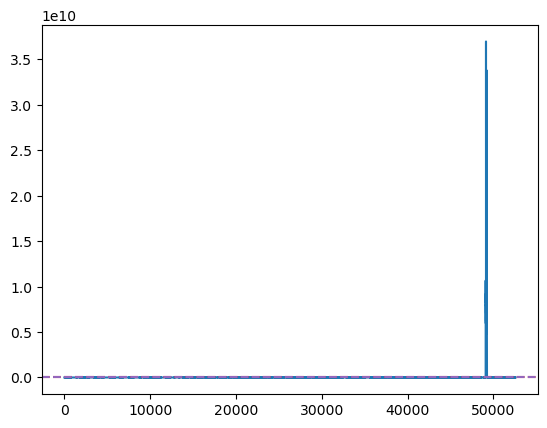

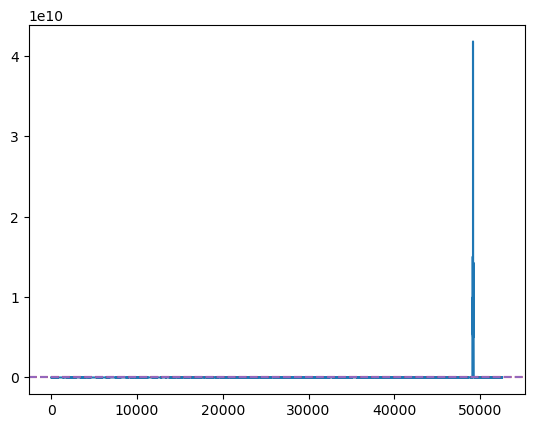

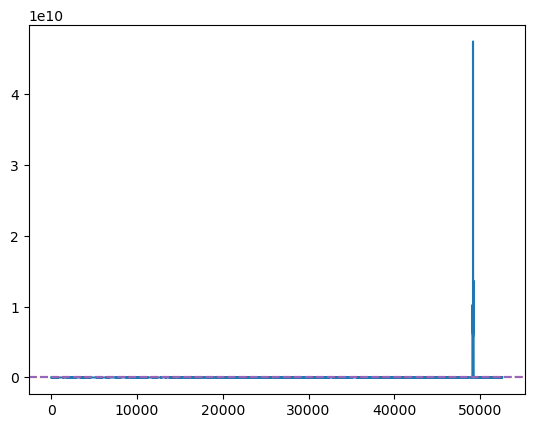

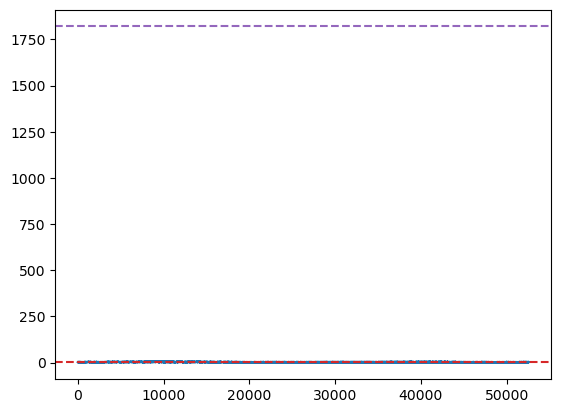

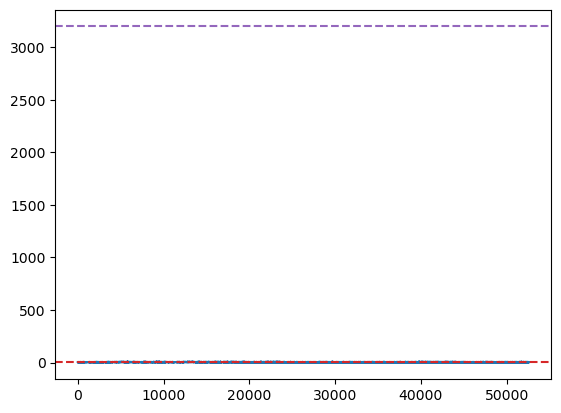

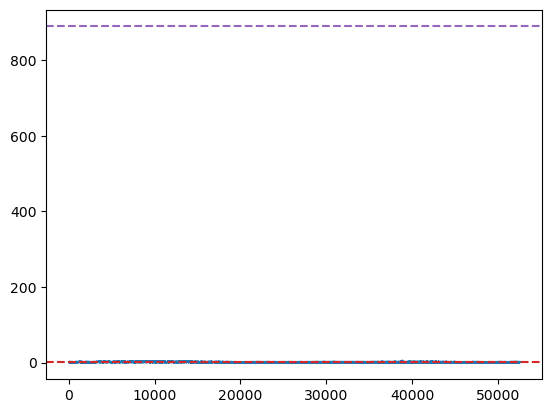

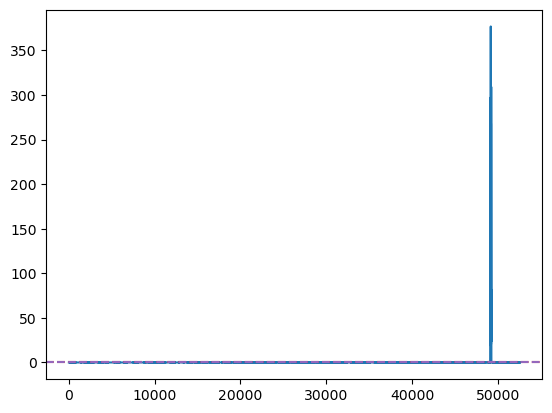

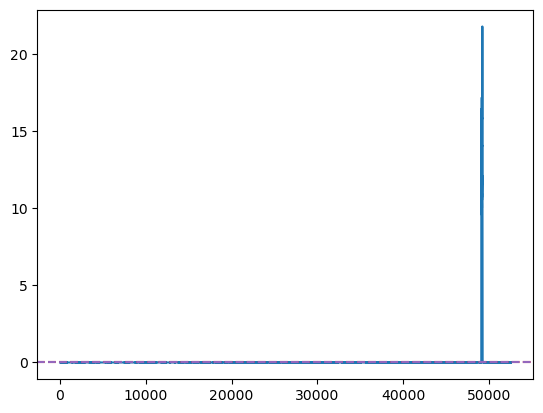

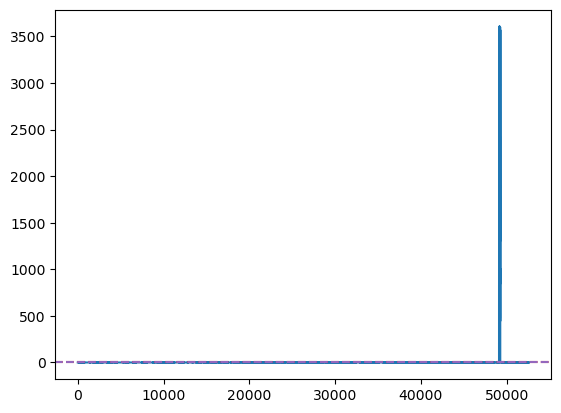

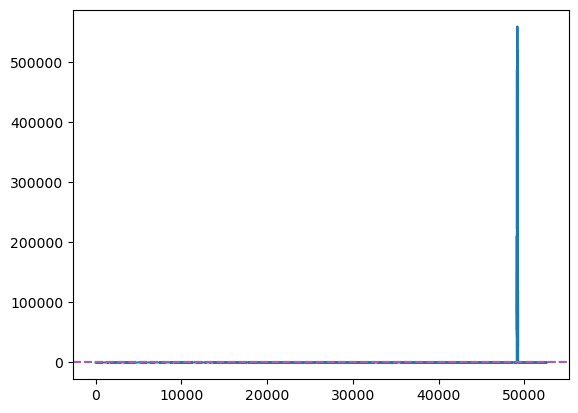

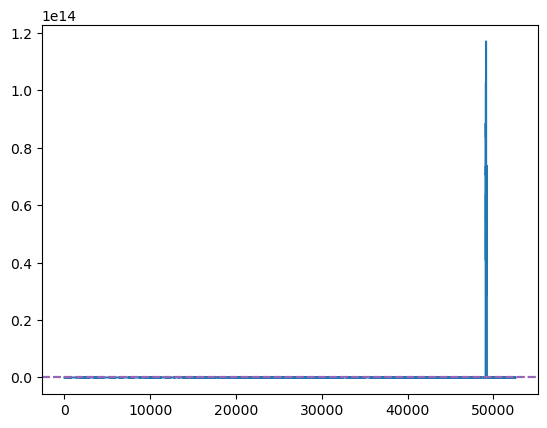

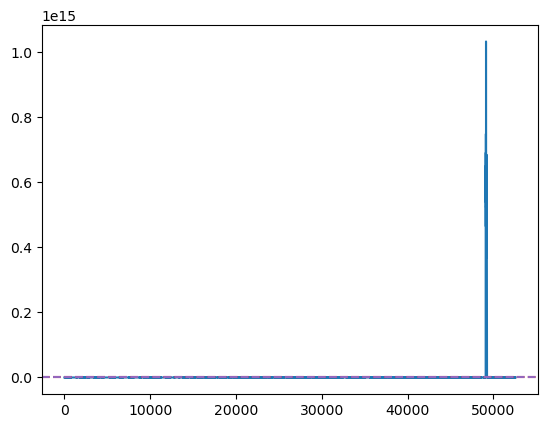

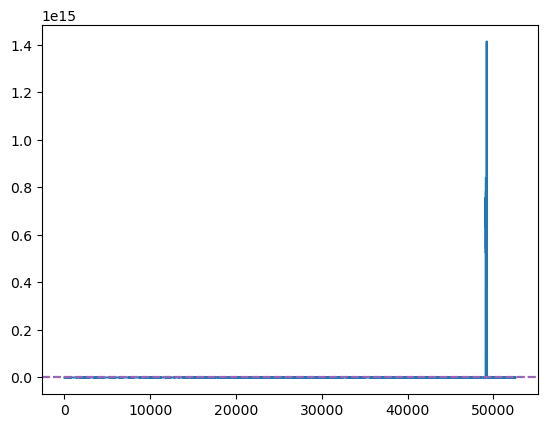

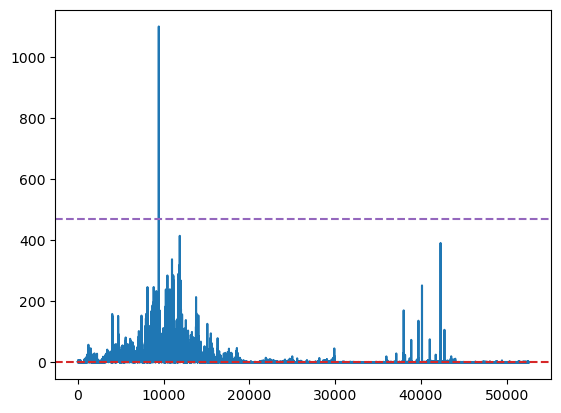

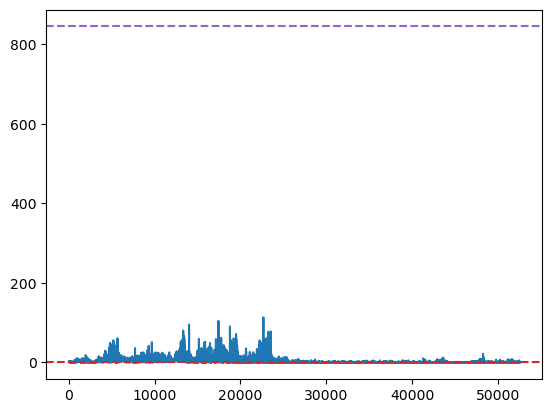

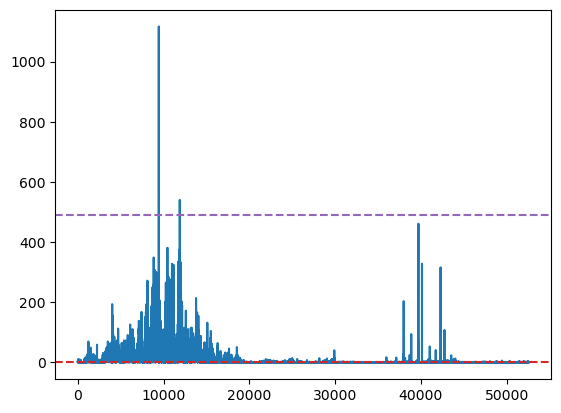

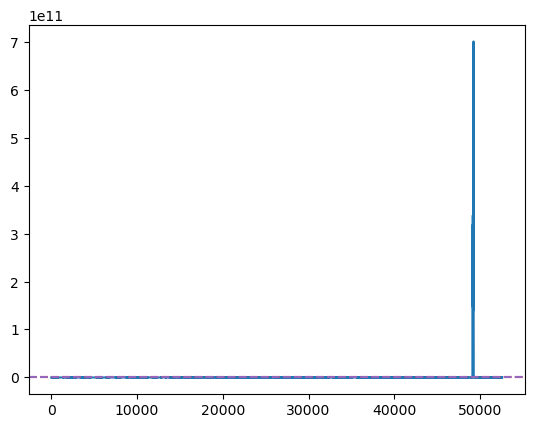

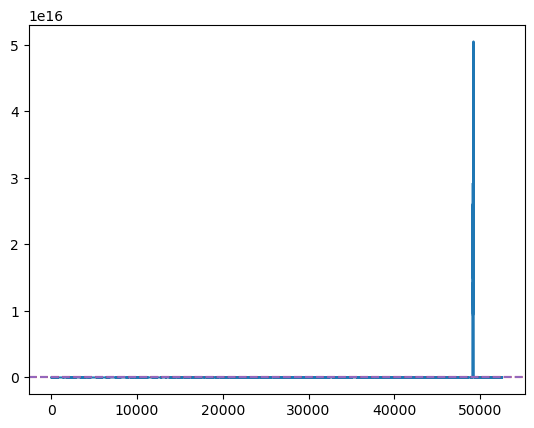

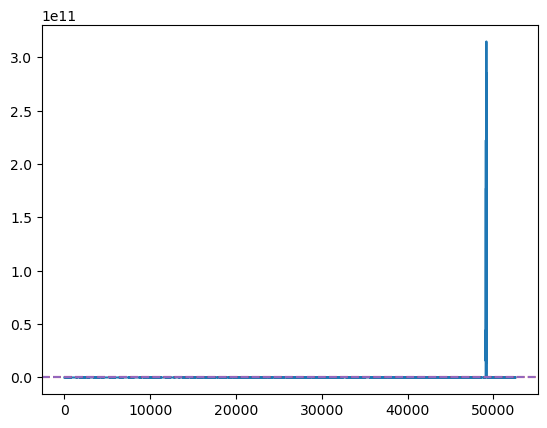

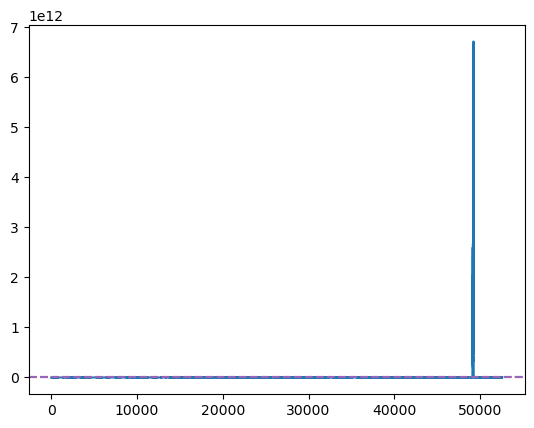

In [522]:
df = pd.read_csv('../{}_{}_extended2.csv'.format(2005,'CDF'))
df.set_index('time',inplace=True)
df.index = pd.to_datetime(df.index).tz_localize(None)
df = df.resample('10min').median()
for i in df.columns:
#     peaks, properties = scipy.signal.find_peaks(df[i], prominence=df[i].mean()-df[i].median())
#     print(df[i].max()-df[i].median())
#     df = df.loc[peaks,i]
    plt.plot(range(len(df[i])),df[i])
#     plt.plot(peaks,df[i][peaks],'x')
    plt.axhline(df[i].median(),linestyle='--',color='C3')
    plt.axhline(df[i].median()*1000,linestyle='--',color='C4')
#     plt.axhline(df[i].median()-(3*df[i].std()),linestyle='--',color='C4')
#     plt.plot(range(len(df[i])),5*df[i].rolling('30D',center=True).std()+df[i].median(),linestyle='--',color='C1')
    plt.show()

In [768]:
!pwd

/home/koepflma/project1/Mt-St-Helens/RSAM_DSAR/code


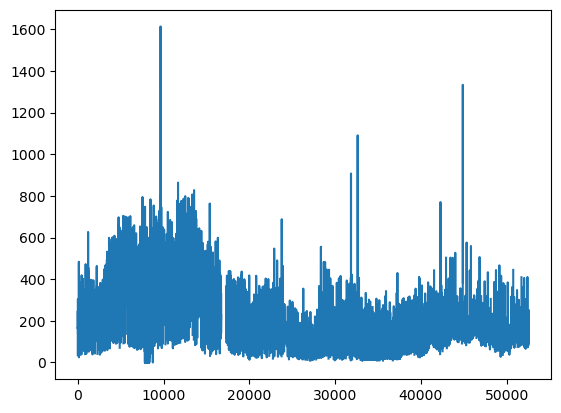

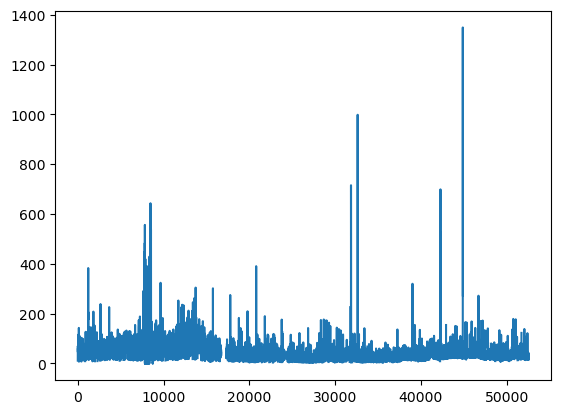

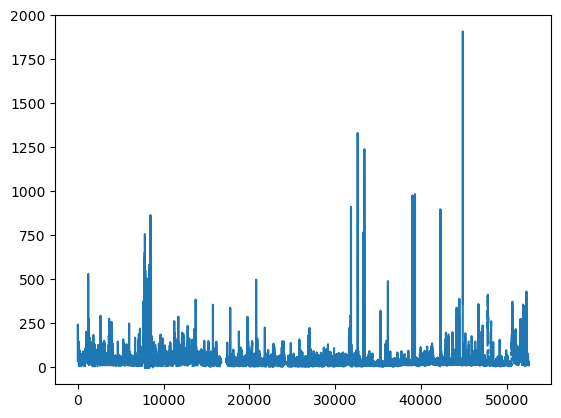

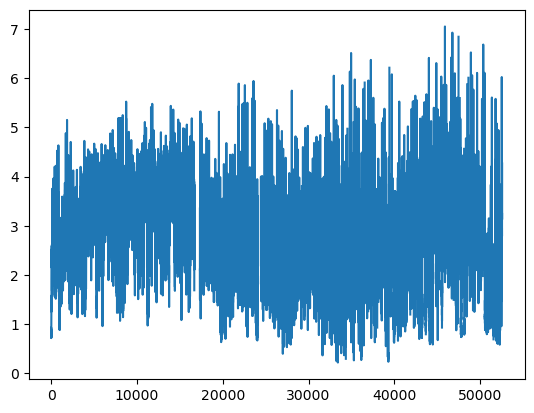

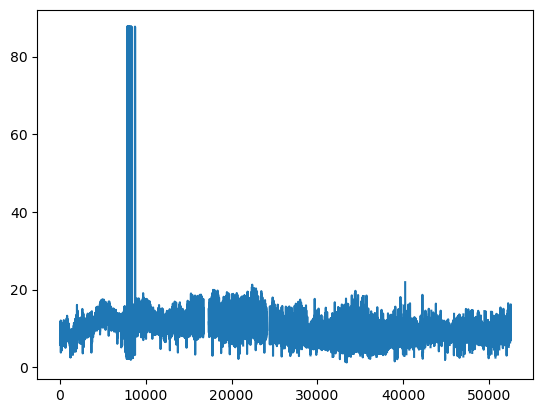

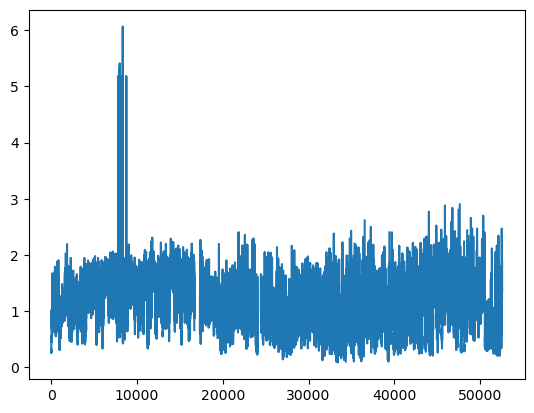

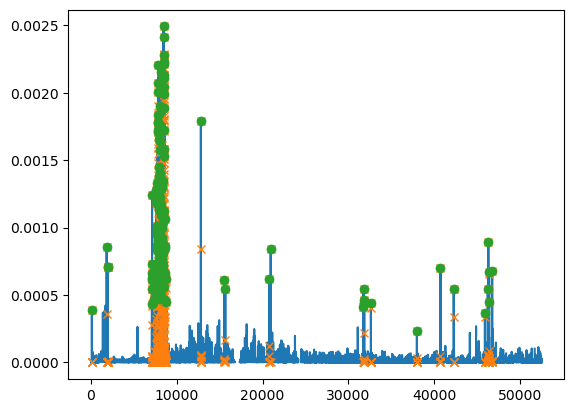

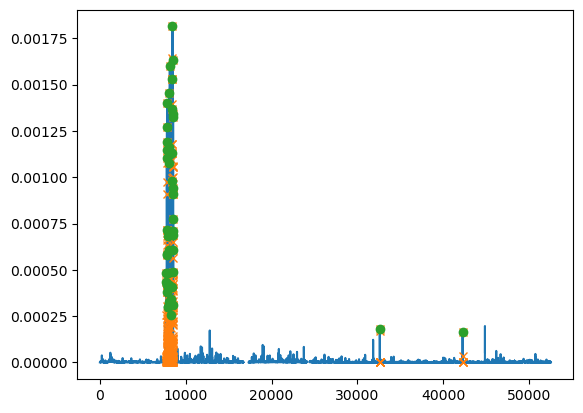

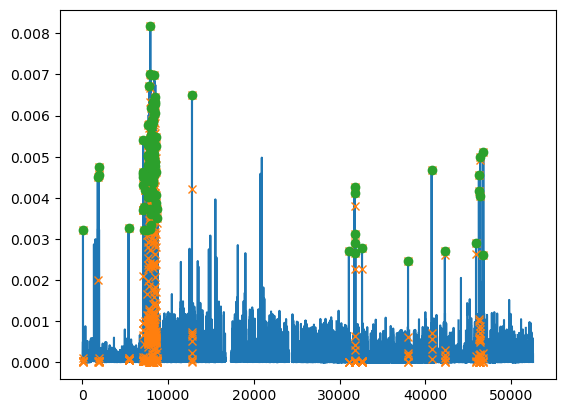

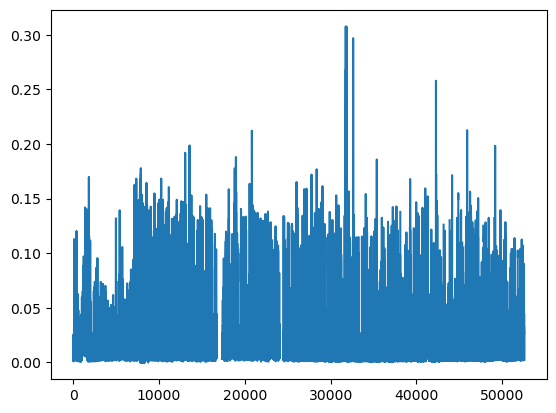

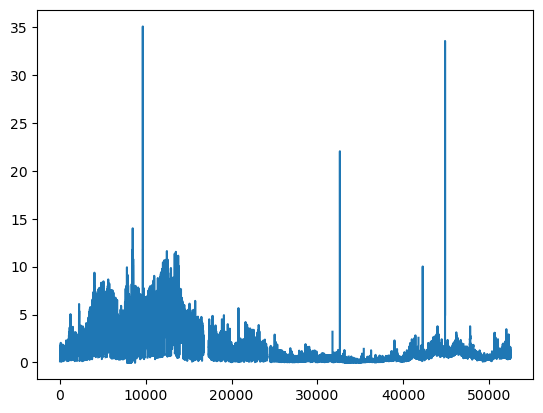

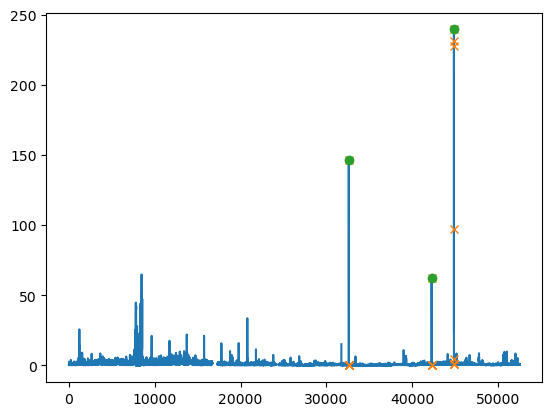

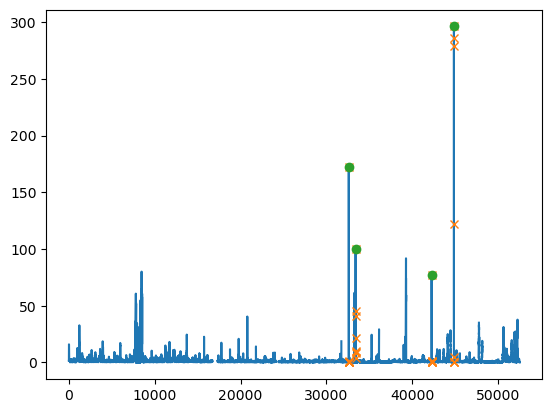

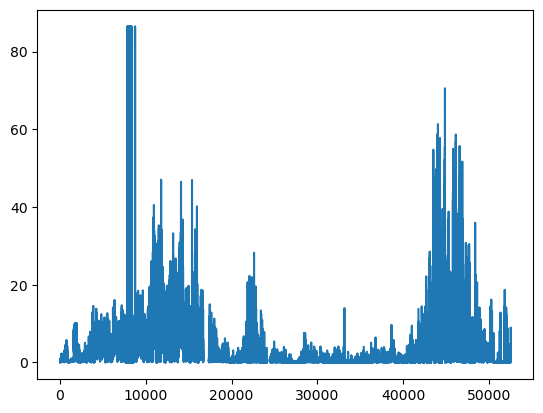

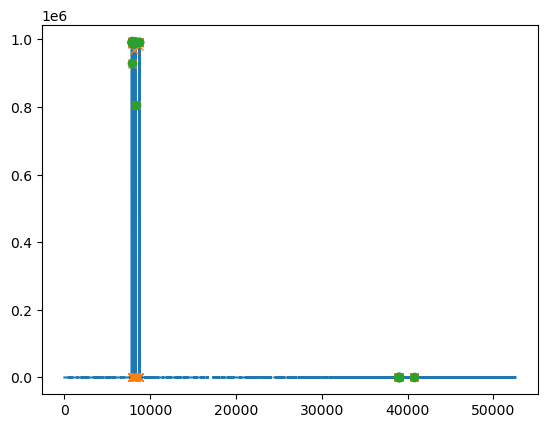

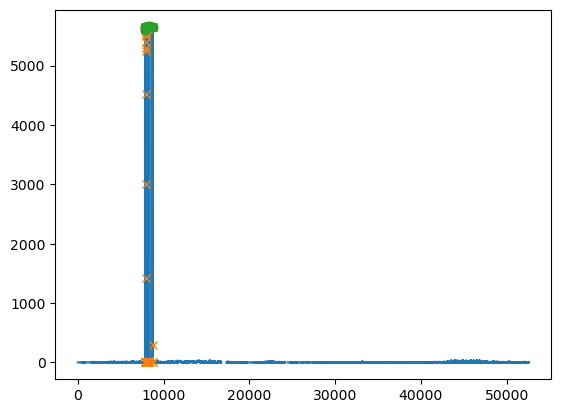

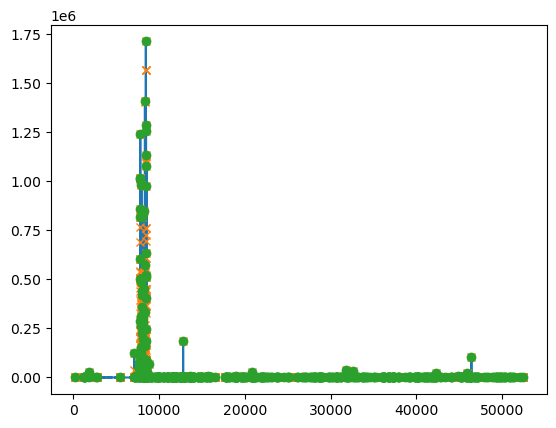

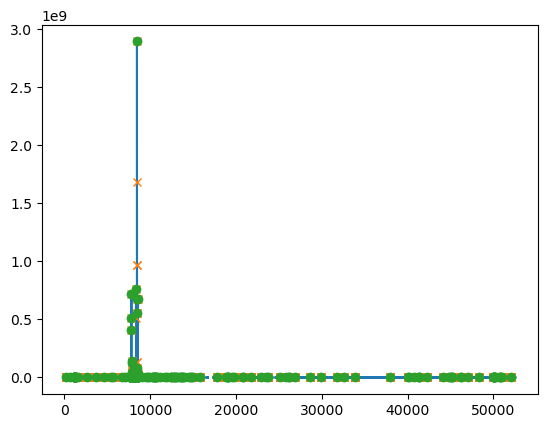

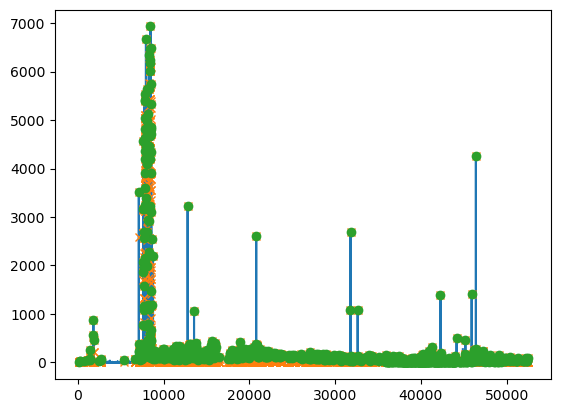

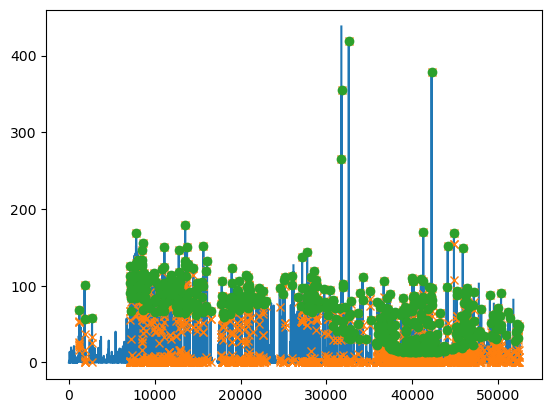

In [767]:
df = pd.read_csv('../{}_{}_extended2.csv'.format(2005,'SHW'))
df.set_index('time',inplace=True)
df.index = pd.to_datetime(df.index).tz_localize(None)
df = df.resample('10min').median()

for i in df.columns:
    peaks, properties = scipy.signal.find_peaks(df[i], prominence=(df[i].rolling('60D').median()*100).to_numpy(),wlen=10)#distance=len(df[i])
    plt.plot(range(len(df[i])),df[i])
    df_new = df[i].copy()
    
    try:
#         print(df_new)
#         df_new[df_new>min(df_new.iloc[properties['left_bases'][0]:properties['right_bases'][0]])*2]=np.nan
        for p in range(len(peaks)):
            df_new.iloc[properties['left_bases'][p]-10:properties['right_bases'][p]+10]=np.nan
            df_new.median()
            plt.plot(range(properties['left_bases'][p],properties['right_bases'][p]),df[i][properties['left_bases'][p]:properties['right_bases'][p]],'x',color='C1')
#         df_new[df_new>df_new.median()]=np.nan
#         plt.plot(range(len(df_new)),df_new,'C3')
        plt.plot(peaks,df[i][peaks],'o',color='C2')
        
    
    except:
        pass
    plt.show()

In [722]:
df_new[df_new>min(df_new.iloc[properties['left_bases'][0]:properties['right_bases'][0]])]

time
2005-02-25 15:10:00    0.351127
2005-02-25 15:20:00    0.351127
2005-02-25 15:30:00    0.370936
2005-02-25 15:40:00    0.490568
2005-02-25 15:50:00    0.490568
                         ...   
2005-12-31 23:00:00    2.288967
2005-12-31 23:10:00    0.882727
2005-12-31 23:20:00    0.882727
2005-12-31 23:30:00    1.577085
2005-12-31 23:40:00    2.531474
Freq: 10T, Name: zsc2_pga, Length: 44548, dtype: float64

In [ ]:

#     if df.index[-1]-df.index[0] > datetime.timedelta(days=50):
#         df_std = 5*df.rolling('30D',center=True).std()+df.median()
#         df_std = df.rolling('30D',center=True).std()+df[i].median()
#         df_std = df.std()
#         df = df[df<df_std]

{'prominences': array([3.06501451e+10]), 'left_bases': array([49141]), 'right_bases': array([49168])}


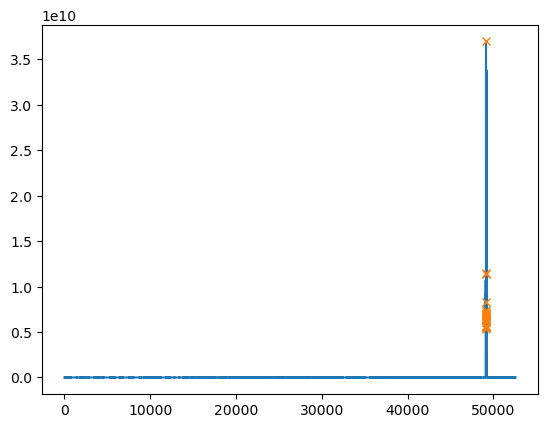

{'prominences': array([3.60966206e+10]), 'left_bases': array([49172]), 'right_bases': array([49390])}


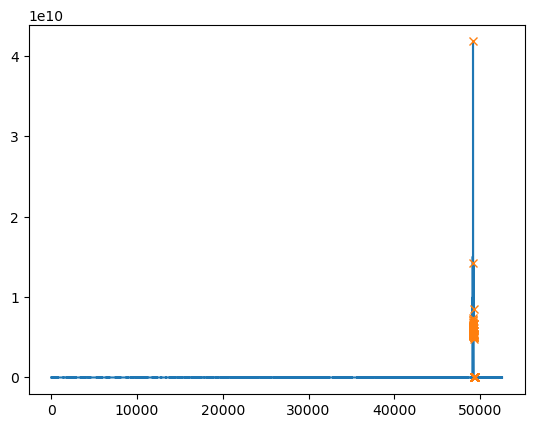

{'prominences': array([4.06218112e+10]), 'left_bases': array([49172]), 'right_bases': array([49247])}


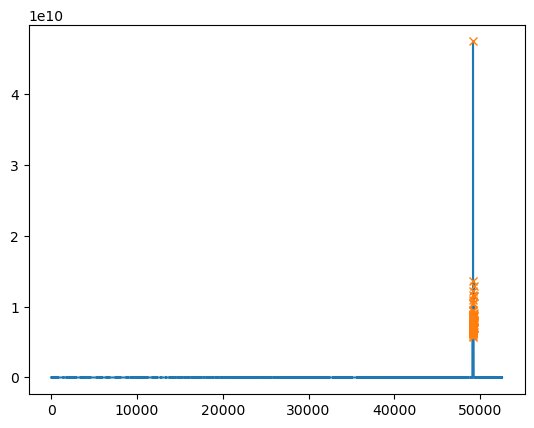

{'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64)}


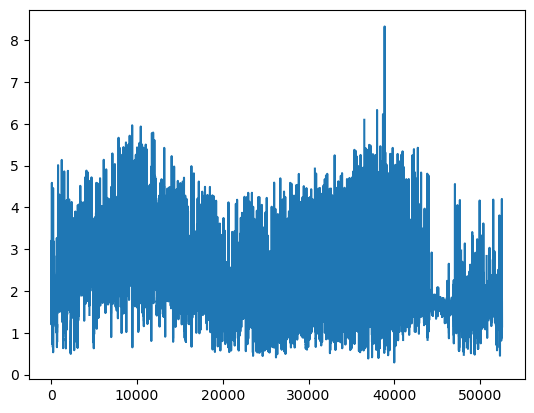

{'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64)}


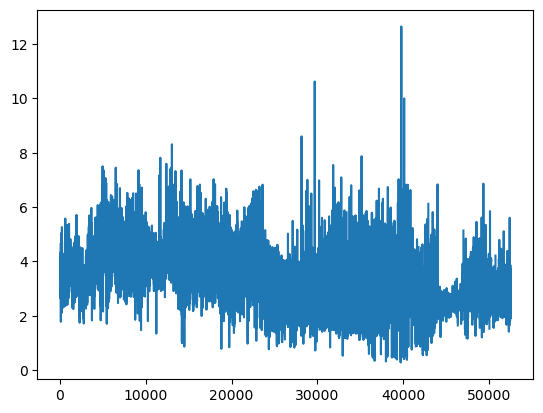

{'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64)}


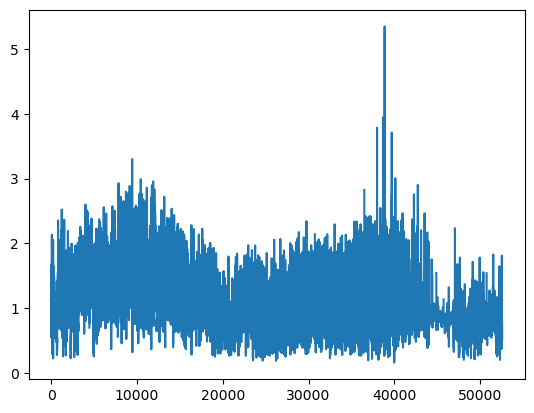

{'prominences': array([351.08936488]), 'left_bases': array([49172]), 'right_bases': array([49247])}


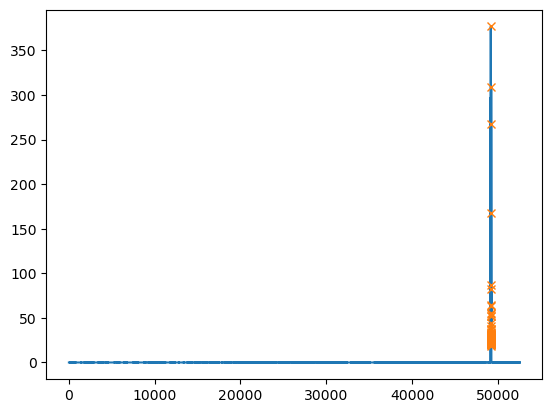

{'prominences': array([12.17632899]), 'left_bases': array([49181]), 'right_bases': array([49247])}


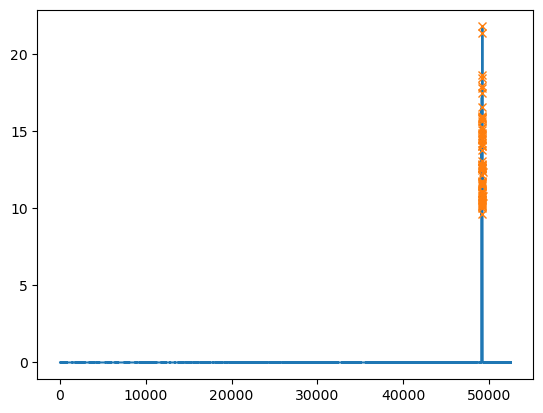

{'prominences': array([3191.60438852]), 'left_bases': array([49141]), 'right_bases': array([49161])}


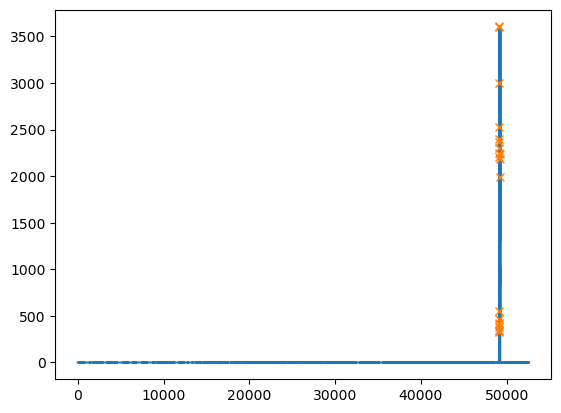

{'prominences': array([395599.99951676]), 'left_bases': array([49172]), 'right_bases': array([49247])}


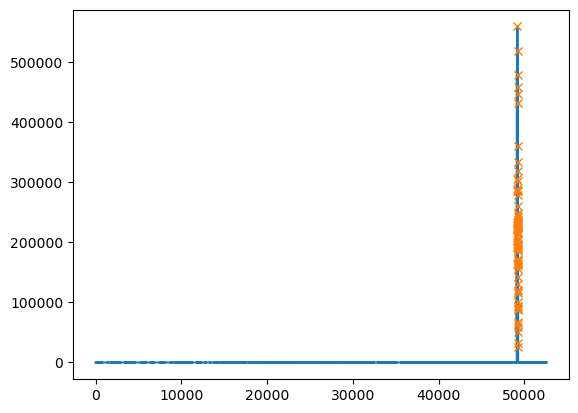

{'prominences': array([7.21200498e+13]), 'left_bases': array([49142]), 'right_bases': array([49168])}


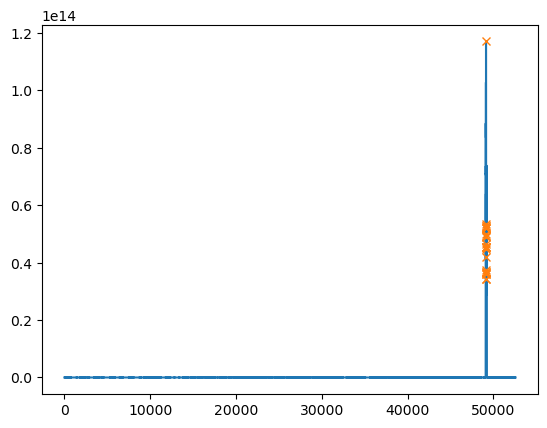

{'prominences': array([5.0870179e+14]), 'left_bases': array([49142]), 'right_bases': array([49169])}


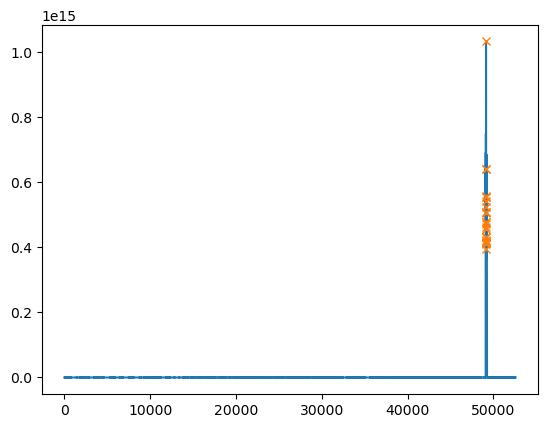

{'prominences': array([1.02842266e+15]), 'left_bases': array([49181]), 'right_bases': array([49247])}


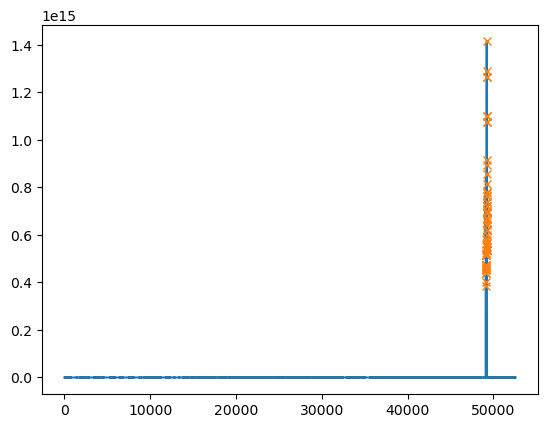

{'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64)}


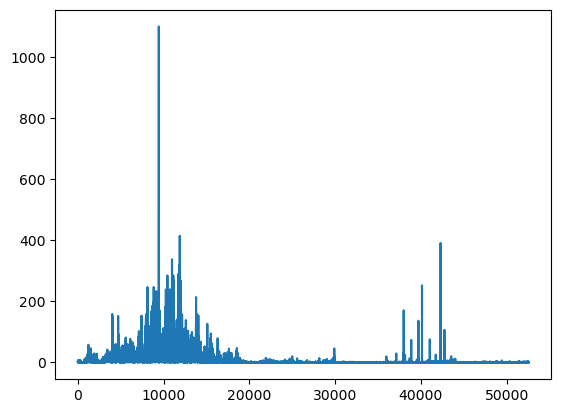

{'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64)}


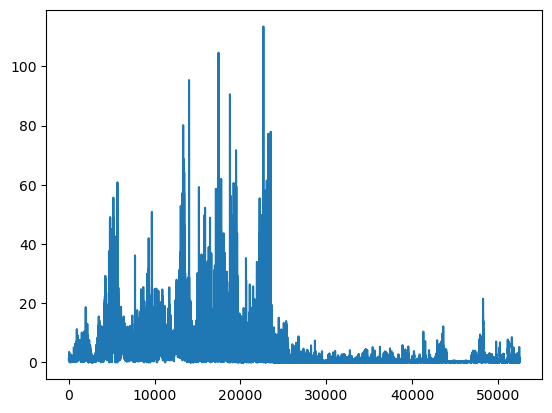

{'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64)}


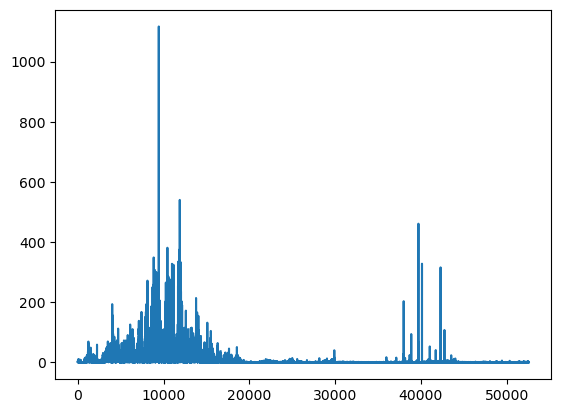

{'prominences': array([5.61112506e+11]), 'left_bases': array([49193]), 'right_bases': array([49247])}


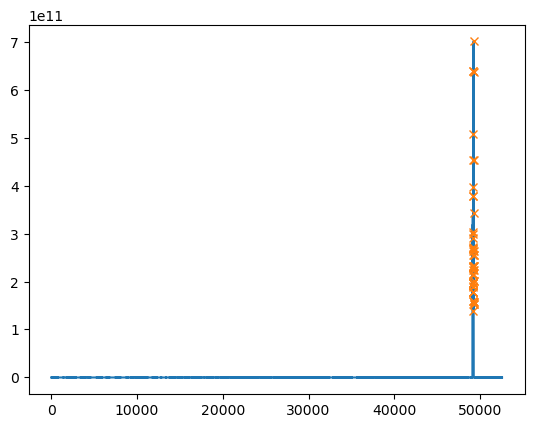

{'prominences': array([4.11487489e+16]), 'left_bases': array([49182]), 'right_bases': array([49247])}


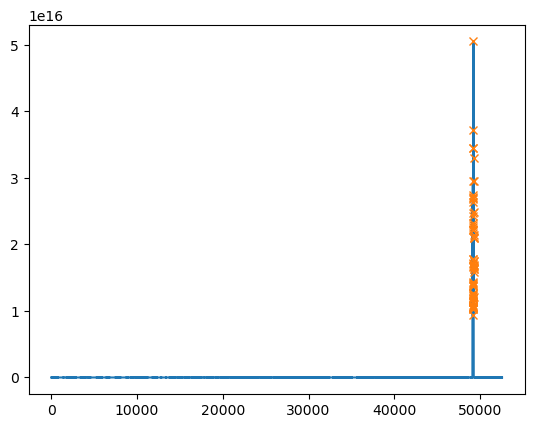

{'prominences': array([1.36607397e+11]), 'left_bases': array([49173]), 'right_bases': array([49247])}


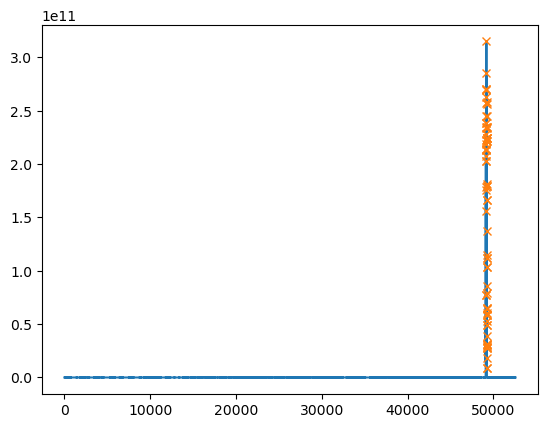

{'prominences': array([6.26200007e+12]), 'left_bases': array([49205]), 'right_bases': array([49247])}


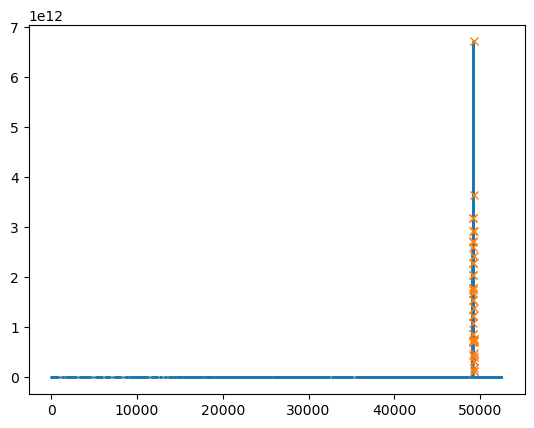

In [585]:
for i in df.columns:
#     peaks, properties = scipy.signal.find_peaks(df[i], prominence=df[i].mean()-df[i].median(),wlen=100)
    peaks, properties = scipy.signal.find_peaks(df[i], prominence=(df[i].rolling('30D').median()*100).to_numpy(), distance=len(df[i]))

    print(properties)
    plt.plot(range(len(df[i])),df[i])
    try:
        plt.plot(range(properties['left_bases'][0],properties['right_bases'][0]),df[i][properties['left_bases'][0]:properties['right_bases'][0]],'x')
    except:
        pass
    plt.show()

In [359]:
df_new = df.iloc[:,:10]
df_zsc = df.iloc[:,10:]
df_zsc.columns = df_new.columns
df_final = df_new[df_new<df_zsc*100]
df = pd.concat([df_final,df.iloc[:,10:]], axis=1)
#     df_new = df.iloc[:,:10]
#     df_zsc = df.iloc[:,10:]
#     df_zsc.columns = df_new.columns
#     df_final = df_new[df_new<df_zsc*5]
#     df = pd.concat([df_final,df.iloc[:,10:]], axis=1)
df

rsam  mf  hf      dsar     ldsar      vsar           rms  \
time                                                                            
2005-01-01 00:10:00   NaN NaN NaN  2.119019  3.193794  1.085986  2.943351e-07   
2005-01-01 00:20:00   NaN NaN NaN  2.119019  3.231553  1.085986  2.951615e-07   
2005-01-01 00:30:00   NaN NaN NaN  2.119019  3.269312  1.085986  2.959880e-07   
2005-01-01 00:40:00   NaN NaN NaN  2.119019  3.275737  1.085986  2.951615e-07   
2005-01-01 00:50:00   NaN NaN NaN  2.119019  3.282163  1.085986  2.959880e-07   
...                   ...  ..  ..       ...       ...       ...           ...   
2005-12-31 23:10:00   NaN NaN NaN  1.895778  3.035503  0.802923  3.556463e-07   
2005-12-31 23:20:00   NaN NaN NaN  1.876106  3.035503  0.802737  3.556513e-07   
2005-12-31 23:30:00   NaN NaN NaN  1.871071  3.035503  0.802551  3.556463e-07   
2005-12-31 23:40:00   NaN NaN NaN  1.866035  3.082122  0.799667  3.556414e-07   
2005-12-31 23:50:00   NaN NaN NaN  1.801567  3.082122  0.796783  3.550724e-07   

                             rmes       pgv       pga  zsc2_rsam   zsc2_mf  \
time                                                                         
2005-01-01 00:10:00  1.981067e-07  0.000001  0.000126   0.914088  0.959304   
2005-01-01 00:20:00  1.986423e-07  0.000001  0.000127   0.918384  0.969945   
2005-01-01 00:30:00  1.991778e-07  0.000001  0.000127   0.922681  0.980586   
2005-01-01 00:40:00  1.986423e-07  0.000001  0.000127   0.926484  0.981938   
2005-01-01 00:50:00  1.991778e-07  0.000001  0.000127   0.930287  0.983291   
...                           ...       ...       ...        ...       ...   
2005-12-31 23:10:00  2.379423e-07  0.000002  0.000253   0.640050  0.730813   
2005-12-31 23:20:00  2.384639e-07  0.000002  0.000254   0.641145  0.725872   
2005-12-31 23:30:00  2.379423e-07  0.000002  0.000253   0.626738  0.707216   
2005-12-31 23:40:00  2.374208e-07  0.000002  0.000254   0.612332  0.688561   
2005-12-31 23:50:00  2.371498e-07  0.000002  0.000259   0.626738  0.707216   

                      zsc2_hf  zsc2_dsar  zsc2_ldsar  zsc2_vsar  zsc2_rms  \
time                                                                        
2005-01-01 00:10:00  0.706527   1.399121    0.901336   1.691881  0.419719   
2005-01-01 00:20:00  0.718497   1.399121    0.961767   1.691881  0.419293   
2005-01-01 00:30:00  0.730466   1.399121    1.022198   1.691881  0.419719   
2005-01-01 00:40:00  0.746396   1.314659    1.022198   1.562661  0.419293   
2005-01-01 00:50:00  0.762326   1.230196    1.022198   1.433441  0.418868   
...                       ...        ...         ...        ...       ...   
2005-12-31 23:10:00  0.792782   0.307417    0.528112   0.237877  0.548806   
2005-12-31 23:20:00  0.803385   0.300105    0.528112   0.237877  0.548933   
2005-12-31 23:30:00  0.852604   0.300105    0.528112   0.235534  0.552707   
2005-12-31 23:40:00  0.901824   0.300105    0.528112   0.233190  0.548679   
2005-12-31 23:50:00  0.963831   0.278482    0.528112   0.223749  0.546983   

                     zsc2_rmes  zsc2_pgv  zsc2_pga  
time                                                
2005-01-01 00:10:00   0.610384  0.250588  0.331450  
2005-01-01 00:20:00   0.583513  0.250588  0.331450  
2005-01-01 00:30:00   0.610384  0.250588  0.331450  
2005-01-01 00:40:00   0.583513  0.257656  0.349648  
2005-01-01 00:50:00   0.556641  0.264724  0.367847  
...                        ...       ...       ...  
2005-12-31 23:10:00   0.893667  0.406120  0.970907  
2005-12-31 23:20:00   0.893667  0.407047  0.993369  
2005-12-31 23:30:00   0.899271  0.406120  0.993369  
2005-12-31 23:40:00   0.893667  0.405194  0.993369  
2005-12-31 23:50:00   0.893667  0.403130  0.993369  

[52559 rows x 20 columns]

In [831]:
year = 2008

In [832]:
all_files = sorted(glob.glob('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/tmp_{}/*/*.csv'.format(year)))
sta_list = np.unique([file.split('/')[-2] for file in all_files])
for sta in sta_list:
    print(sta)
    sta_files = sorted(glob.glob('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/tmp_{}/{}/*.csv'.format(year,sta)))
    li = []
    for filename in sta_files:
        frame = pd.read_csv(filename)
        li.append(frame)

    df = pd.concat(li, axis=0, ignore_index=True)
    df.set_index('time',inplace=True)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df.sort_index()

    # compute transforms and save
    df['zsc2_rsam'] = zsc2(df['rsam'])
    df['zsc2_mf'] = zsc2(df['mf'])
    df['zsc2_hf'] = zsc2(df['hf'])
    df['zsc2_dsar'] = zsc2(df['dsar'])
    df['zsc2_ldsar'] = zsc2(df['ldsar'])
    df['zsc2_vsar'] = zsc2(df['vsar'])
    df['zsc2_rms'] = zsc2(df['rms'])
    df['zsc2_rmes'] = zsc2(df['rmes'])
    df['zsc2_pgv'] = zsc2(df['pgv'])
    df['zsc2_pga'] = zsc2(df['pga'])

    df.to_csv('../data/{}_{}_extended2.csv'.format(year,sta)) #df.to_csv('.'+os.sep+'SHW_seismic_data_extended.csv')

CDF
EDM
ELK
FL2
HSR
JUN
NED
SEP
SHW
SOS
STD
SUG
SWFL
TDL
VALT


In [836]:
sta = 'EDM'
all_files = sorted(glob.glob('../data/*_{}_extended2.csv'.format(sta)))
print(all_files)
li = []
for filename in all_files:
    frame = pd.read_csv(filename)
    li.append(frame)

df = pd.concat(li, axis=0, ignore_index=True)
df.set_index('time',inplace=True)
df.index = pd.to_datetime(df.index).tz_localize(None)
df.sort_index()
df.to_csv('../{}_extended2_long.csv'.format(sta)) #df.to_csv('.'+os.sep+'SHW_seismic_data_extended.csv')

['../data/2000_EDM_extended2.csv', '../data/2001_EDM_extended2.csv', '../data/2002_EDM_extended2.csv', '../data/2003_EDM_extended2.csv', '../data/2004_EDM_extended2.csv', '../data/2005_EDM_extended2.csv', '../data/2006_EDM_extended2.csv', '../data/2007_EDM_extended2.csv', '../data/2008_EDM_extended2.csv']


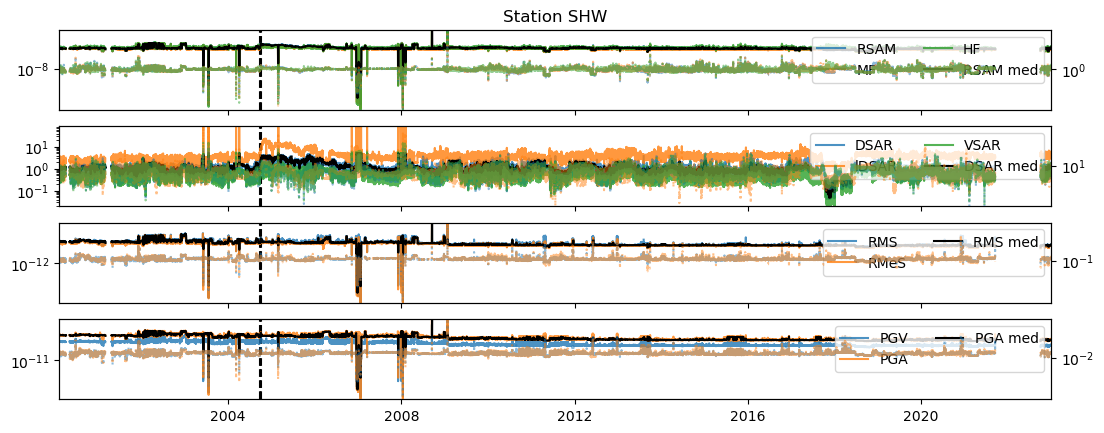

In [17]:
# all_files = sorted(glob.glob('../{}_*_extended2.csv'.format(year)))
# sta_list = np.unique([file.split('/')[1].split('_')[1] for file in all_files])
# year = 2000
sta_list = ['SHW']
for sta in sta_list:
#     df = pd.read_csv('../data/{}_{}_extended2.csv'.format(year,sta))
    df = pd.read_csv('../data/{}_extended2_long2.csv'.format(sta))
    df.set_index('time',inplace=True)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df = df.resample('10min').median()
    
#     df = df.apply(mask_df,axis=0) # remove outliers (the peak detection does not work well)
        
    df = df.rolling('6H', center=True, closed='both').median()
    df['rsam_median'] = df['rsam'].rolling('2D').median()
    df['zsc2_rsam_median'] = df['zsc2_rsam'].rolling('2D').median()
    df['dsar_median'] = df['dsar'].rolling('2D').median()
    df['zsc2_dsar_median'] = df['zsc2_dsar'].rolling('2D').median()
    df['rms_median'] = df['rms'].rolling('2D').median()
    df['zsc2_rms_median'] = df['zsc2_rms'].rolling('2D').median()
    df['pga_median'] = df['pga'].rolling('2D').median()
    df['zsc2_pga_median'] = df['zsc2_pga'].rolling('2D').median()
#     df = df.resample('1H').median()

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True, figsize=(6.4*2, 4.8))

    ax1.plot(df['rsam'], label='RSAM', alpha=0.8)
    ax1.plot(df['mf'], label='MF', alpha=0.8)
    ax1.plot(df['hf'], label='HF', alpha=0.8)
    ax1.plot(df['rsam_median'], label='RSAM med',color='k')
    ax1.set_ylim(min(df['rsam'].min(),df['mf'].min(),df['hf'].min()),max(df['rsam'].max(),df['mf'].max(),df['hf'].max()))

    ax11 = ax1.twinx()
    ax11.plot(df['zsc2_rsam'],linestyle=':', alpha=0.5)
    ax11.plot(df['zsc2_mf'], linestyle=':', alpha=0.5)
    ax11.plot(df['zsc2_hf'], linestyle=':', alpha=0.5)
    ax11.set_ylim(min(df['zsc2_rsam'].min(),df['zsc2_mf'].min(),df['zsc2_hf'].min()),max(df['zsc2_rsam'].max(),df['zsc2_mf'].max(),df['zsc2_hf'].max()))

    ax2.plot(df['dsar'], label='DSAR', alpha=0.8)
    ax2.plot(df['ldsar'], label='lDSAR', alpha=0.8)
    ax2.plot(df['vsar'], label='VSAR', alpha=0.8)
    ax2.plot(df['dsar_median'], label='DSAR med',color='k')
    ax2.set_ylim(min(df['dsar'].min(),df['ldsar'].min(),df['vsar'].min()),max(df['dsar'].max(),df['ldsar'].max(),df['vsar'].max()))

    ax22 = ax2.twinx()
    ax22.plot(df['zsc2_dsar'],linestyle=':', alpha=0.5)
    ax22.plot(df['zsc2_ldsar'], linestyle=':', alpha=0.5)
    ax22.plot(df['zsc2_vsar'], linestyle=':', alpha=0.5)
    ax22.set_ylim(min(df['zsc2_dsar'].min(),df['zsc2_ldsar'].min(),df['zsc2_vsar'].min()),
                  max(df['zsc2_dsar'].max(),df['zsc2_ldsar'].max(),df['zsc2_vsar'].max()))
#     ax2.plot(df['zsc2_dsar'], label='zscDSAR', color='C4', alpha=0.5)
#     ax2.plot(df['zsc2_dsar_median'], label='median zscDSAR', color='k')

    ax3.plot(df['rms'], label='RMS', alpha=0.8)
    ax3.plot(df['rmes'], label='RMeS', alpha=0.8)
    ax3.plot(df['rms_median'], label='RMS med',color='k')
#     ax3.plot(df['pgv'], label='PGV', alpha=0.8)
#     ax3.plot(df['pga'], label='PGA', alpha=0.8)
#     ax3.set_ylim(0,max(df['rms'].max(),df['rmes'].max(),df['pgv'].max(),df['pga'].max())) # linear
    ax3.set_ylim(min(df['rms'].min(),df['rmes'].min()),max(df['rms'].max(),df['rmes'].max()))


    ax33 = ax3.twinx()
    ax33.plot(df['zsc2_rms'],linestyle=':', alpha=0.5)
    ax33.plot(df['zsc2_rmes'], linestyle=':', alpha=0.5)
#     ax33.plot(df['zsc2_pgv'], linestyle=':', alpha=0.5)
#     ax33.plot(df['zsc2_pga'], linestyle=':', alpha=0.5)
#     ax33.set_ylim(0,max(df['zsc2_rms'].max(),df['zsc2_rmes'].max(),df['zsc2_pgv'].max(),df['zsc2_pga'].max())) # linear
    ax33.set_ylim(min(df['zsc2_rms'].min(),df['zsc2_rmes'].min()),max(df['zsc2_rms'].max(),df['zsc2_rmes'].max()))      

    ax4.plot(df['pgv'], label='PGV', alpha=0.8)
    ax4.plot(df['pga'], label='PGA', alpha=0.8)
    ax4.plot(df['pga_median'], label='PGA med',color='k')
    ax4.set_ylim(min(df['pgv'].min(),df['pga'].min()),max(df['pgv'].max(),df['pga'].max())) # linear

    ax44 = ax4.twinx()
    ax44.plot(df['zsc2_pgv'], linestyle=':', alpha=0.5)
    ax44.plot(df['zsc2_pga'], linestyle=':', alpha=0.5)
    ax44.set_ylim(min(df['zsc2_pgv'].min(),df['zsc2_pga'].min()),max(df['zsc2_pgv'].max(),df['zsc2_pga'].max()))
    
    ax1.set_xlim(df.index[0], df.index[-1])
    ax1.vlines(UTCDateTime('2004-09-23T09:00:00'),ax1.get_ylim()[0],ax1.get_ylim()[-1], 'k','--')
    ax2.vlines(UTCDateTime('2004-09-23T09:00:00'),ax2.get_ylim()[0],ax2.get_ylim()[-1], 'k','--')
    ax3.vlines(UTCDateTime('2004-09-23T09:00:00'),ax3.get_ylim()[0],ax3.get_ylim()[-1], 'k','--')
    ax4.vlines(UTCDateTime('2004-09-23T09:00:00'),ax4.get_ylim()[0],ax4.get_ylim()[-1], 'k','--')
    
    ax1.vlines(UTCDateTime('2004-10-01T19:00:00'),ax1.get_ylim()[0],ax1.get_ylim()[-1], 'k','--')
    ax2.vlines(UTCDateTime('2004-10-01T19:00:00'),ax2.get_ylim()[0],ax2.get_ylim()[-1], 'k','--')
    ax3.vlines(UTCDateTime('2004-10-01T19:00:00'),ax3.get_ylim()[0],ax3.get_ylim()[-1], 'k','--')
    ax4.vlines(UTCDateTime('2004-10-01T19:00:00'),ax4.get_ylim()[0],ax4.get_ylim()[-1], 'k','--')

    ax1.set_title('Station {}'.format(sta))
    ax1.legend(ncol=2, loc='upper right')
    ax2.legend(ncol=2, loc='upper right')
    ax3.legend(ncol=2, loc='upper right')
    ax4.legend(ncol=2, loc='upper right')
    
    ax1.set_yscale('log');ax11.set_yscale('log')
    ax2.set_yscale('log');ax22.set_yscale('log')
    ax3.set_yscale('log');ax33.set_yscale('log')
    ax4.set_yscale('log');ax44.set_yscale('log')

    
#     file_path = '../plots/{}/'.format(year)
    file_path = '../plots/'
    if not os.path.exists(file_path): # create path if not exist
        os.makedirs(file_path)
#     plt.savefig(file_path+'{}_{}_log_long.png'.format(year,year,sta), dpi=300, bbox_inches='tight')
    plt.savefig(file_path+'{}_log_long.png'.format(sta), dpi=300, bbox_inches='tight')
    fig.show()

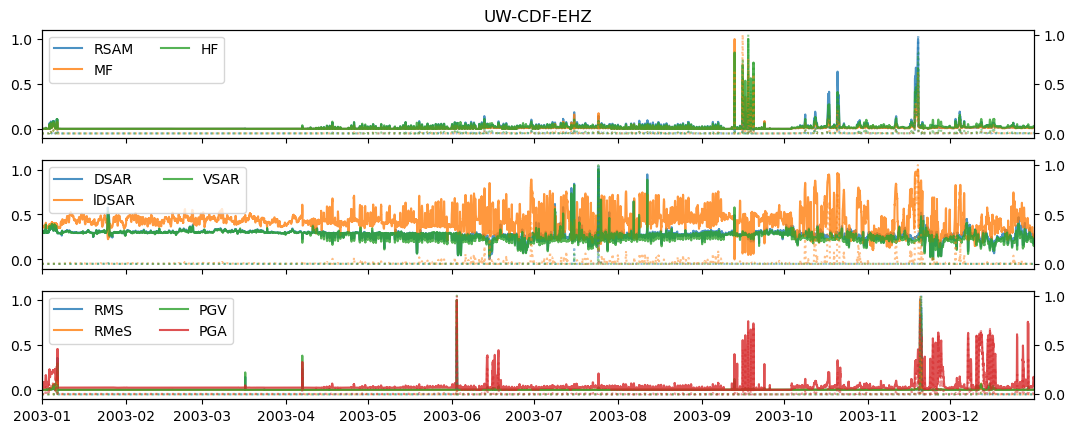

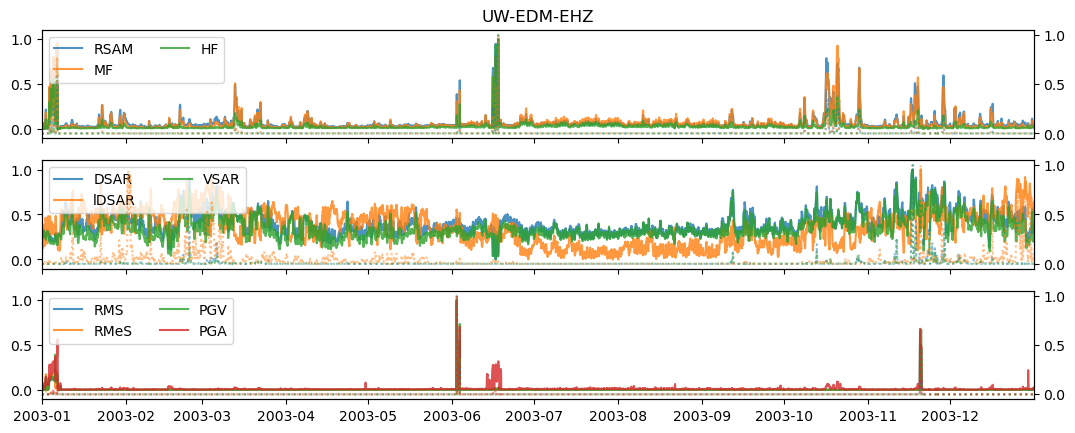

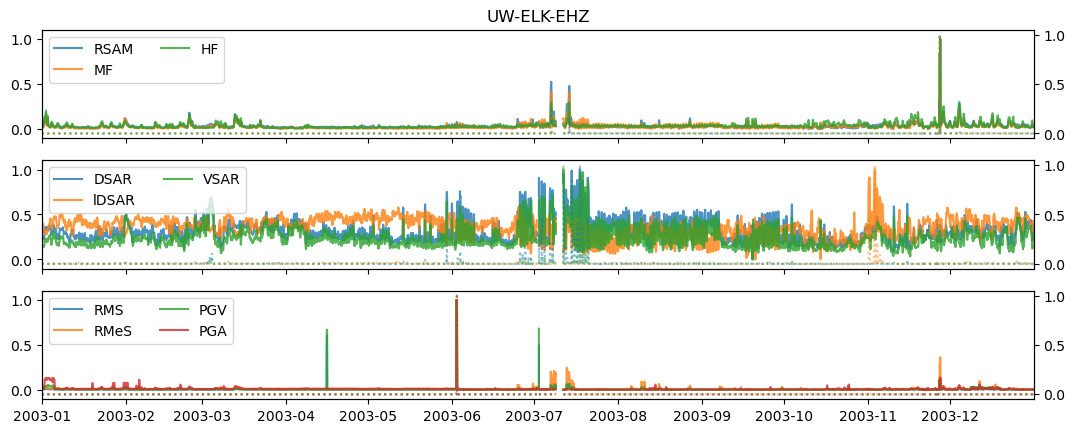

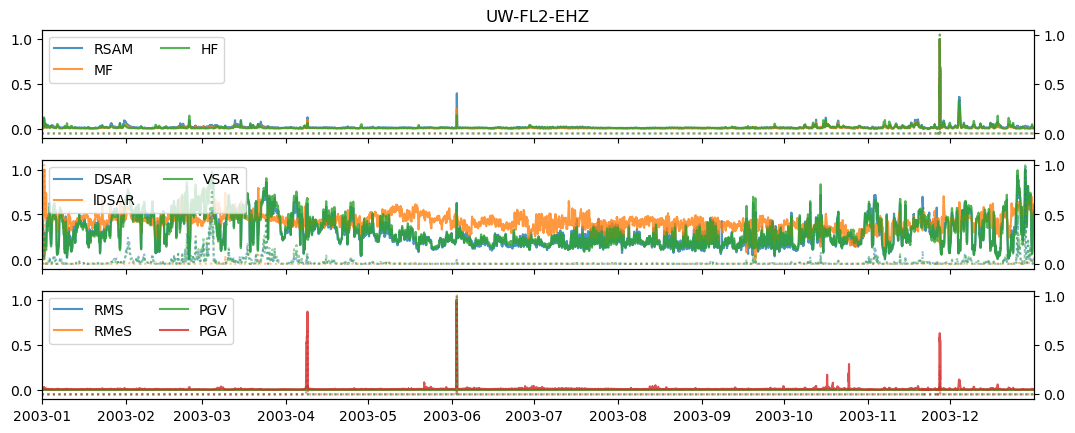

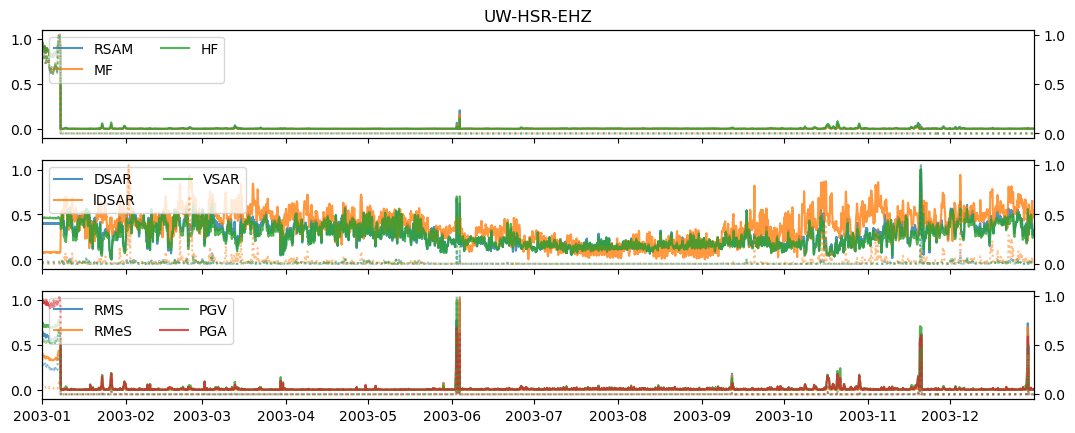

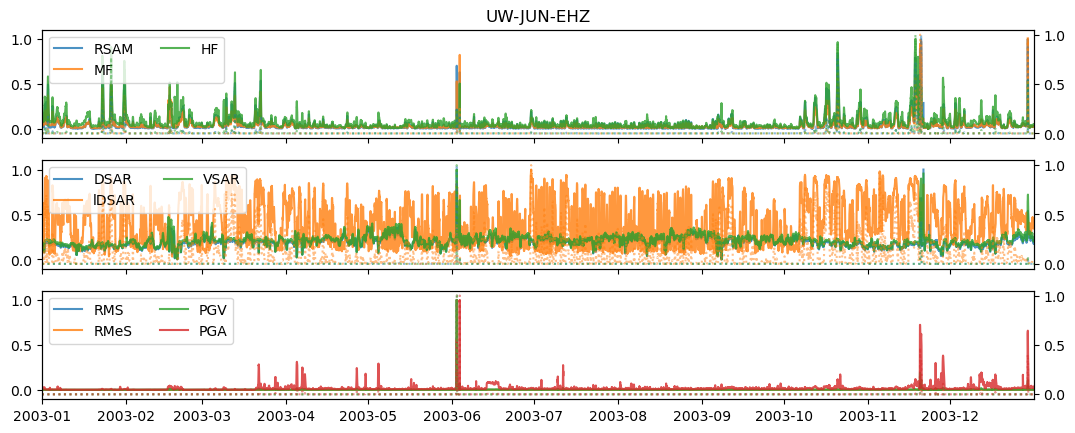

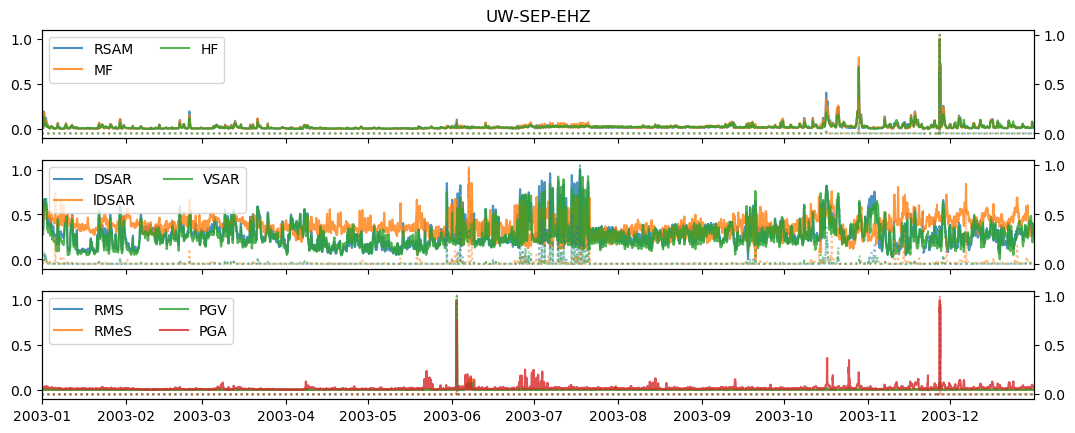

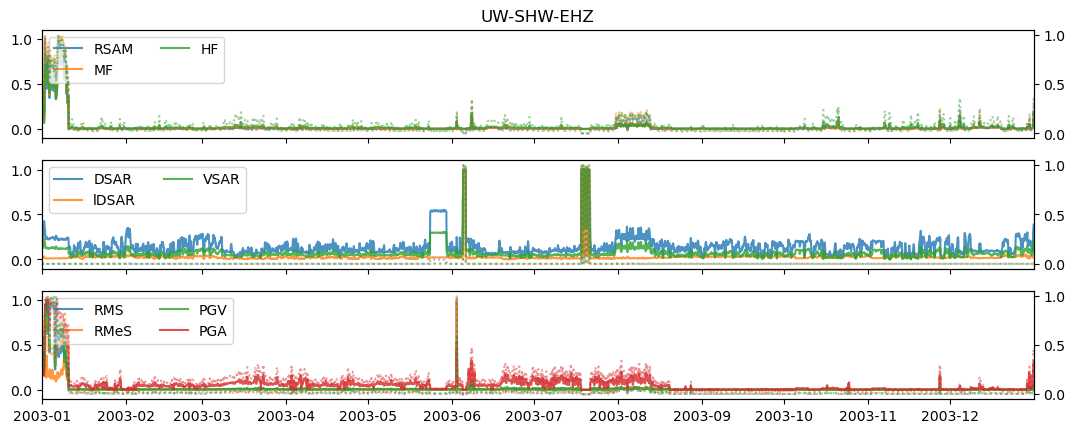

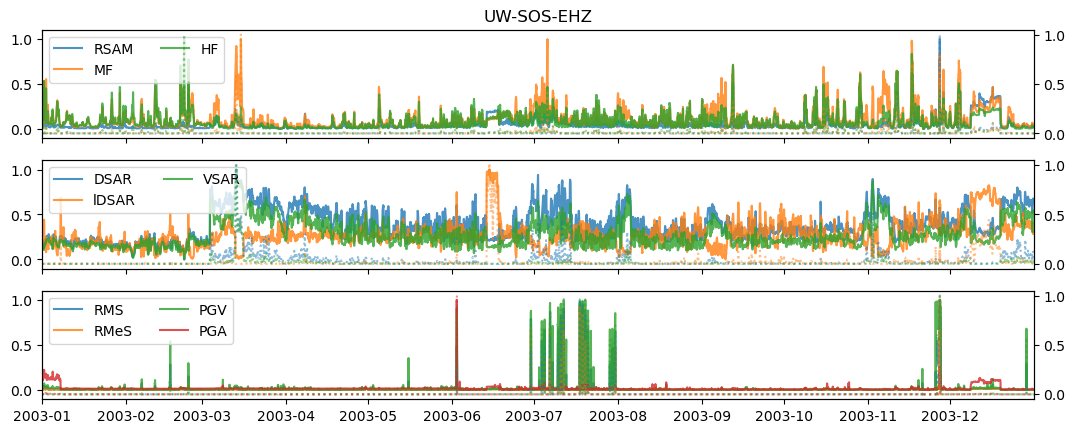

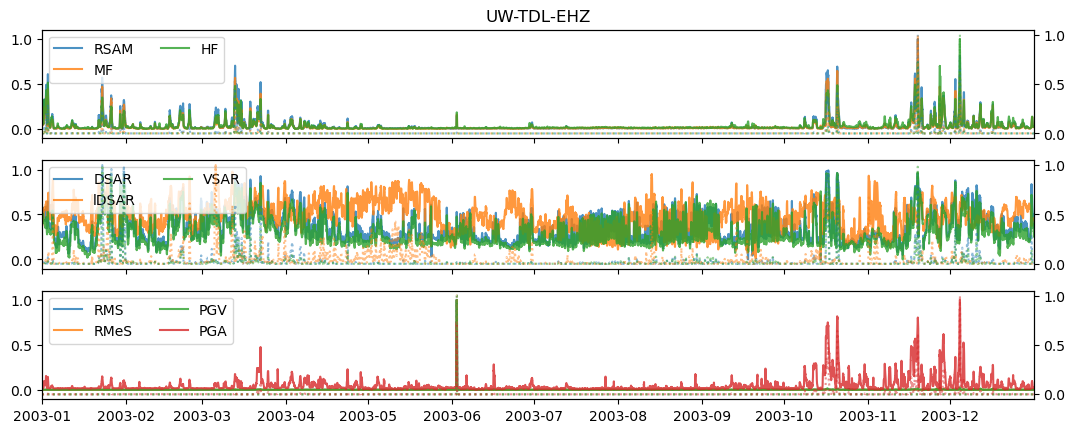

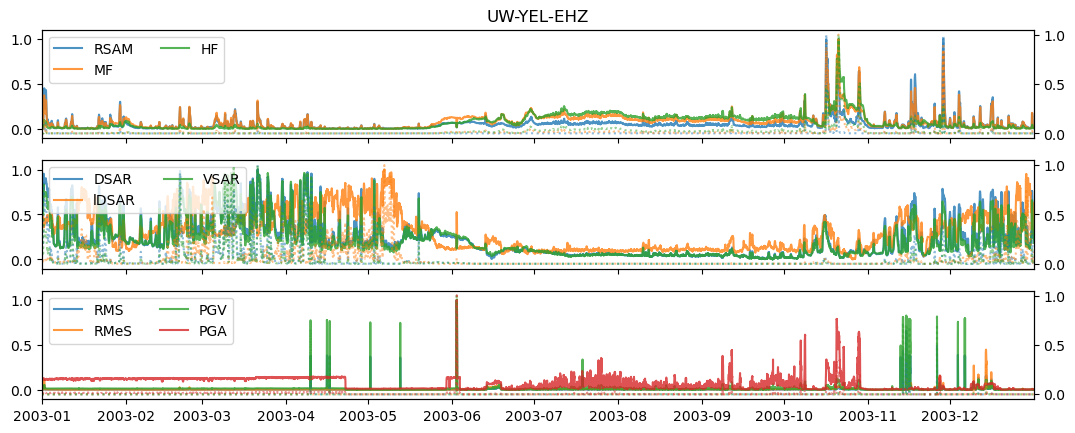

In [242]:
# NORMALIZED plot
year = 2004
sta_list = ['SEP']
# or for all avaivable stations
# all_files = sorted(glob.glob('../data/{}_*_extended2.csv'.format(year)))
# sta_list = np.unique([file.split('/')[2].split('_')[1] for file in all_files])
#============================================================================================
for sta in sta_list:
    df = pd.read_csv('../data/{}_{}_extended2.csv'.format(year,sta)) # read data from csv
#     df = pd.read_csv('../{}_extended2_long.csv'.format(sta))
    df.set_index('time',inplace=True) # set time as index
    df.index = pd.to_datetime(df.index).tz_localize(None) # convert time to datetime
    df = df.resample('10min').median() # resample to 10 min if data gaps
    
    df = df.apply(mask_df,axis=0) # remove outliers (the peak detection does not work well)
        
    df = df.rolling('6H', center=True).median() # roll over 6 hours and take median (whole df)
#     df = df.resample('1H').median() # resample over 1 hour and take median (whole df)
    # roll over 2 days and take median (column of interest)
    df['rsam_median'] = df['rsam'].rolling('2D').median() 
    df['zsc2_rsam_median'] = df['zsc2_rsam'].rolling('2D').median()
    df['dsar_median'] = df['dsar'].rolling('2D').median()
    df['zsc2_dsar_median'] = df['zsc2_dsar'].rolling('2D').median()
    df['rms_median'] = df['rms'].rolling('2D').median()
    df['zsc2_rms_median'] = df['zsc2_rms'].rolling('2D').median()
    df['pga_median'] = df['pga'].rolling('2D').median()
    df['zsc2_pga_median'] = df['zsc2_pga'].rolling('2D').median()

    df = df.apply(norm,axis=0) # normalize all timesiries individual
    
# start plotting ========================================================================================
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True, figsize=(6.4*2, 4.8*1.5))
    
    # first subplot left side ---------------------------------------------------------------------------
    ax1.plot(df['rsam'], label='RSAM', alpha=0.8)
    ax1.plot(df['mf'], label='MF', alpha=0.8)
    ax1.plot(df['hf'], label='HF', alpha=0.8)
    ax1.plot(df['rsam_median'], label='RSAM med',color='k')

    # first subplot right side ---------------------------------------------------------------------------
    ax11 = ax1.twinx()
    ax11.plot(df['zsc2_rsam'],linestyle=':', alpha=0.5)
    ax11.plot(df['zsc2_mf'], linestyle=':', alpha=0.5)
    ax11.plot(df['zsc2_hf'], linestyle=':', alpha=0.5)

    # second subplot left side ---------------------------------------------------------------------------
    ax2.plot(df['dsar'], label='DSAR', alpha=0.8)
    ax2.plot(df['ldsar'], label='lDSAR', alpha=0.8)
    ax2.plot(df['vsar'], label='VSAR', alpha=0.8)
    ax2.plot(df['dsar_median'], label='DSAR med',color='k')

    # second subplot right side ---------------------------------------------------------------------------
    ax22 = ax2.twinx()
    ax22.plot(df['zsc2_dsar'],linestyle=':', alpha=0.5)
    ax22.plot(df['zsc2_ldsar'], linestyle=':', alpha=0.5)
    ax22.plot(df['zsc2_vsar'], linestyle=':', alpha=0.5)
#     ax2.plot(df['zsc2_dsar'], label='zscDSAR', color='C4', alpha=0.5)
#     ax2.plot(df['zsc2_dsar_median'], label='median zscDSAR', color='k')

    # third subplot left side ---------------------------------------------------------------------------
    ax3.plot(df['rms'], label='RMS', alpha=0.8)
    ax3.plot(df['rmes'], label='RMeS', alpha=0.8)
    ax3.plot(df['rms_median'], label='RMS med',color='k')
#     ax3.plot(df['pgv'], label='PGV', alpha=0.8)
#     ax3.plot(df['pga'], label='PGA', alpha=0.8)

    # third subplot right side ---------------------------------------------------------------------------
    ax33 = ax3.twinx()
    ax33.plot(df['zsc2_rms'],linestyle=':', alpha=0.5)
    ax33.plot(df['zsc2_rmes'], linestyle=':', alpha=0.5)
#     ax33.plot(df['zsc2_pgv'], linestyle=':', alpha=0.5)
#     ax33.plot(df['zsc2_pga'], linestyle=':', alpha=0.5)

    # fourth subplot left side ---------------------------------------------------------------------------
    ax4.plot(df['pgv'], label='PGV', alpha=0.8)
    ax4.plot(df['pga'], label='PGA', alpha=0.8)
    ax4.plot(df['pga_median'], label='PGA med',color='k')

    # fourth subplot right side ---------------------------------------------------------------------------
    ax44 = ax4.twinx()
    ax44.plot(df['zsc2_pgv'], linestyle=':', alpha=0.5)
    ax44.plot(df['zsc2_pga'], linestyle=':', alpha=0.5)
    
    # vertical line fror eruption date ----------------------------------------------------------------
    ax1.vlines(UTCDateTime('2004-09-23T09:00:00'),ax1.get_ylim()[0],ax1.get_ylim()[-1], 'k','--')
    ax2.vlines(UTCDateTime('2004-09-23T09:00:00'),ax2.get_ylim()[0],ax2.get_ylim()[-1], 'k','--')
    ax3.vlines(UTCDateTime('2004-09-23T09:00:00'),ax3.get_ylim()[0],ax3.get_ylim()[-1], 'k','--')
    ax4.vlines(UTCDateTime('2004-09-23T09:00:00'),ax4.get_ylim()[0],ax4.get_ylim()[-1], 'k','--')
    
    ax1.vlines(UTCDateTime('2004-10-01T19:00:00'),ax1.get_ylim()[0],ax1.get_ylim()[-1], 'k','--')
    ax2.vlines(UTCDateTime('2004-10-01T19:00:00'),ax2.get_ylim()[0],ax2.get_ylim()[-1], 'k','--')
    ax3.vlines(UTCDateTime('2004-10-01T19:00:00'),ax3.get_ylim()[0],ax3.get_ylim()[-1], 'k','--')
    ax4.vlines(UTCDateTime('2004-10-01T19:00:00'),ax4.get_ylim()[0],ax4.get_ylim()[-1], 'k','--')

    # legend  ---------------------------------------------------------------------------
    ax1.legend(ncol=2, loc='upper left')
    ax2.legend(ncol=2, loc='upper left')
    ax3.legend(ncol=2, loc='upper left')
    ax4.legend(ncol=2, loc='upper left')
    
    ax1.set_title('Station {}'.format(sta))
    
#     file_path = '../plots/{}/'.format(year)
#     if not os.path.exists(file_path): # create path if not exist
#         os.makedirs(file_path)
#     plt.savefig('../plots/{}/{}_{}_norm.png'.format(year,year,sta), dpi=300, bbox_inches='tight')

    fig.show()

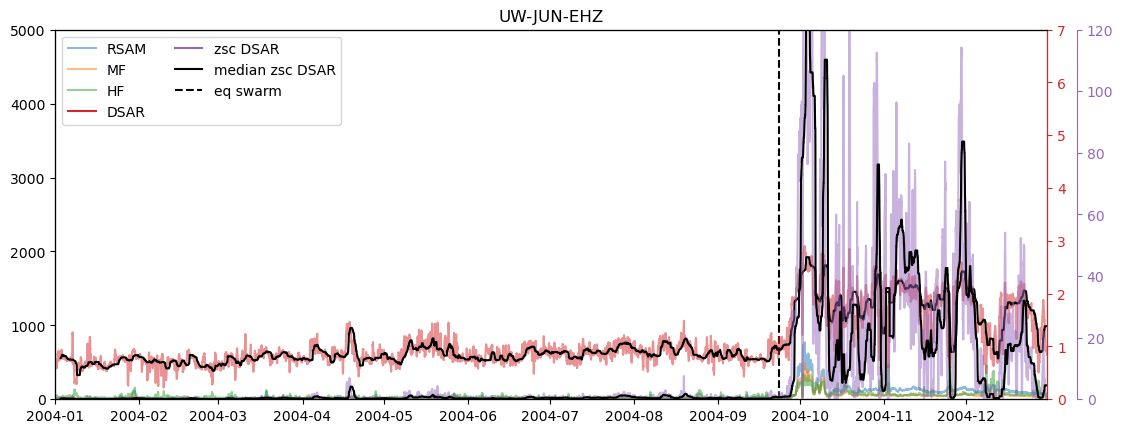

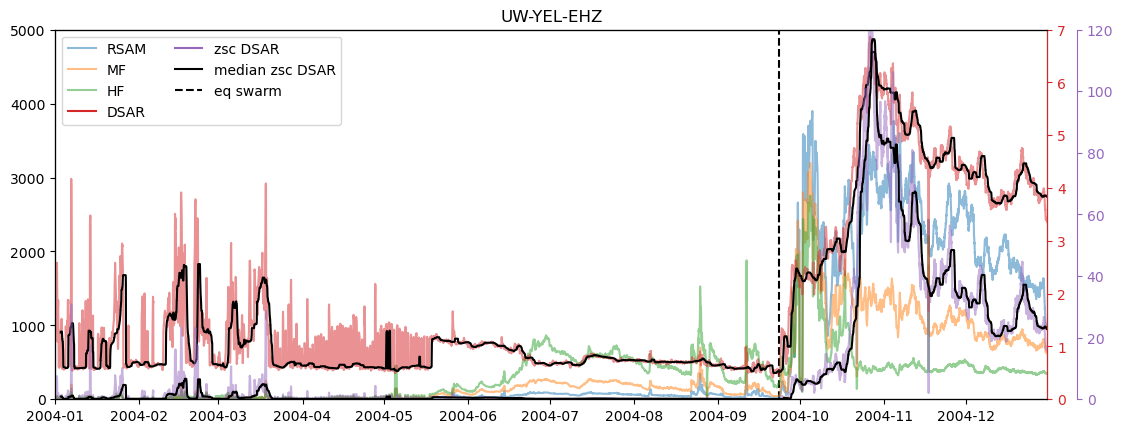

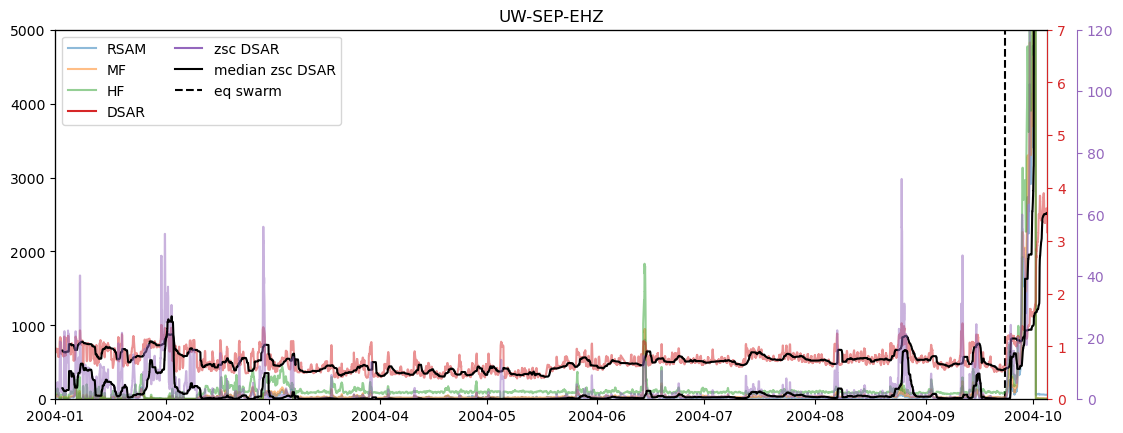

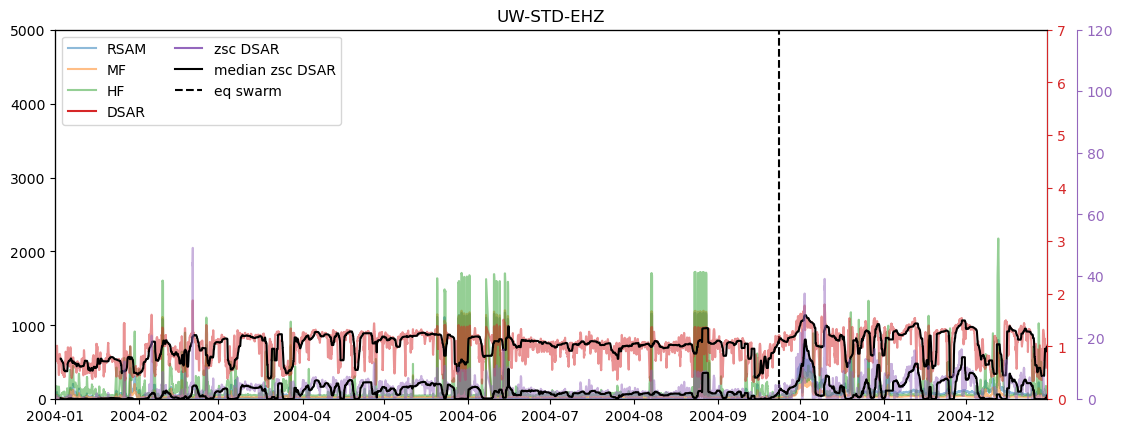

In [121]:
sta_list = ['JUN','YEL','SEP','STD','EDM','SHW','HSR','SOS','TDL','ELK','FL2','CDF']
for sta in sta_list:
#     all_files = sorted(glob.glob('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/{}/*.csv'.format(sta)))
#     li = []
#     for filename in all_files:
#         frame = pd.read_csv(filename)
#         li.append(frame)

#     df = pd.concat(li, axis=0, ignore_index=True)
#     df.set_index('time',inplace=True)
#     df.index = pd.to_datetime(df.index).tz_localize(None)
#     df.sort_index()

#     # compute transforms and save
#     df['zsc2_rsam'] = zsc2(df['rsam'])
#     df['zsc2_mf'] = zsc2(df['mf'])
#     df['zsc2_hf'] = zsc2(df['hf'])
#     df['zsc2_dsar'] = zsc2(df['dsar'])

#     df.to_csv('../{}_extended.csv'.format(sta)) #df.to_csv('.'+os.sep+'SHW_seismic_data_extended.csv')
       
    df = pd.read_csv('../{}_extended.csv'.format(sta))
    df.set_index('time',inplace=True)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df = df.rolling('6H', center=True).median()
    df['dsar_median'] = df[['dsar']].rolling(2*24*6).median()
    df['zsc2_dsar_median'] = df[['zsc2_dsar']].rolling(2*24*6).median()
    # df = df.resample('1H').median()

    fig, ax = plt.subplots(1,1, sharex=True, figsize=(6.4*2, 4.8))

    ax.plot(df['rsam'], label='RSAM', alpha=0.5)
    ax.plot(df['mf'], label='MF', alpha=0.5)
    ax.plot(df['hf'], label='HF', alpha=0.5)
    ax.plot(np.nan, label='DSAR')
    ax.plot(np.nan, label='zsc DSAR')
    ax.plot(np.nan, label='median zsc DSAR', color='k')
    ax.plot(np.nan, label='eq swarm', color='k',linestyle='--')
    ax.set_ylim(0,5e3) # linear
    # ax.set_ylim(1e-2,1e4) # log
    # ax.set_yscale('log')

    ax2 = ax.twinx()
    ax2.spines.right.set_color('C3')
    ax2.tick_params(axis='y', colors='C3')
    ax2.tick_params(axis='y', colors='C3')
    ax2.plot(df['dsar'], label='DSAR', color='C3', alpha=0.5)
    ax2.plot(df['dsar_median'], label='median DSAR', color='k')
    ax2.set_ylim(0,7)

    ax3 = ax.twinx()
    ax3.spines.right.set_position(("axes", 1.03))
    ax3.spines.right.set_color('C4')
    ax3.tick_params(axis='y', colors='C4')
    ax3.tick_params(axis='y', colors='C4')
    ax3.plot(df['zsc2_dsar'], label='zscDSAR', color='C4', alpha=0.5)
    ax3.plot(df['zsc2_dsar_median'], label='median zscDSAR', color='k')
    ax3.set_ylim(0,120)

    ax.set_xlim(df.index[0], df.index[-1])
    ax.vlines(UTCDateTime('2004-09-23T09:00:00'),ax.get_ylim()[0],ax.get_ylim()[-1], 'k','--')

    ax.set_title('UW-{}-EHZ'.format(sta))
    ax.legend(ncol=2, loc='upper left')
    fig.show()

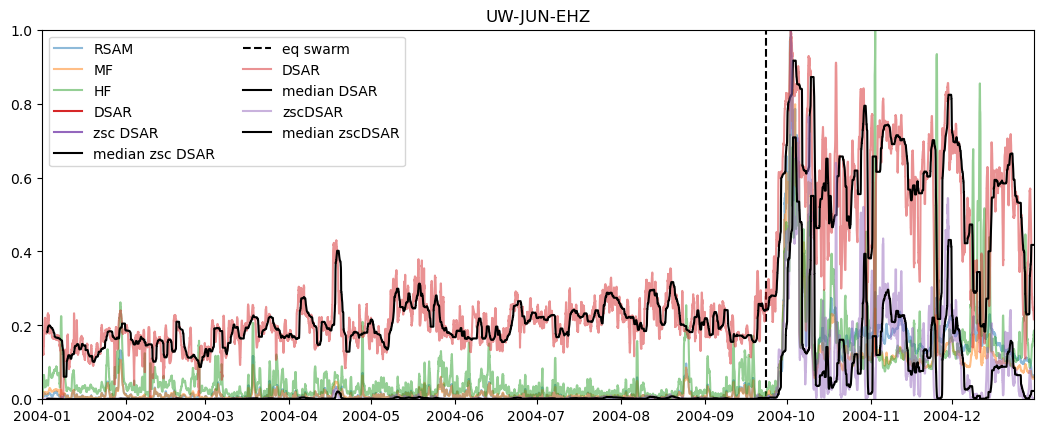

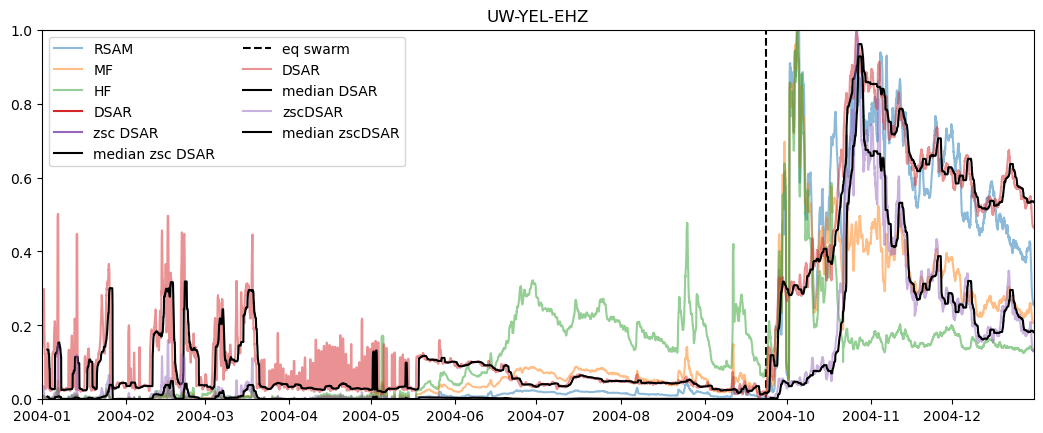

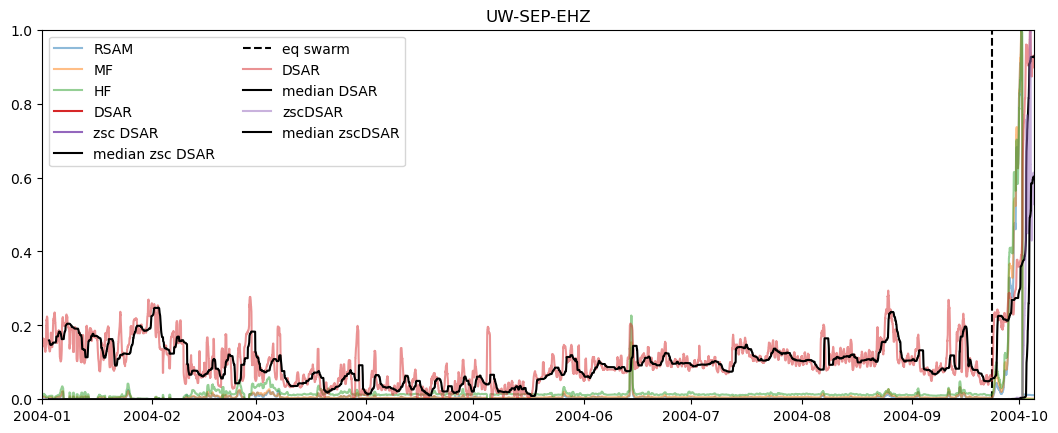

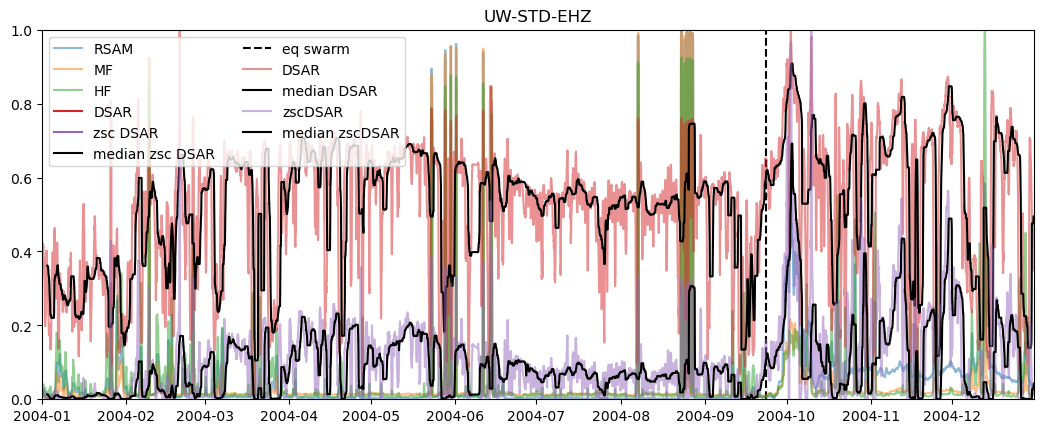

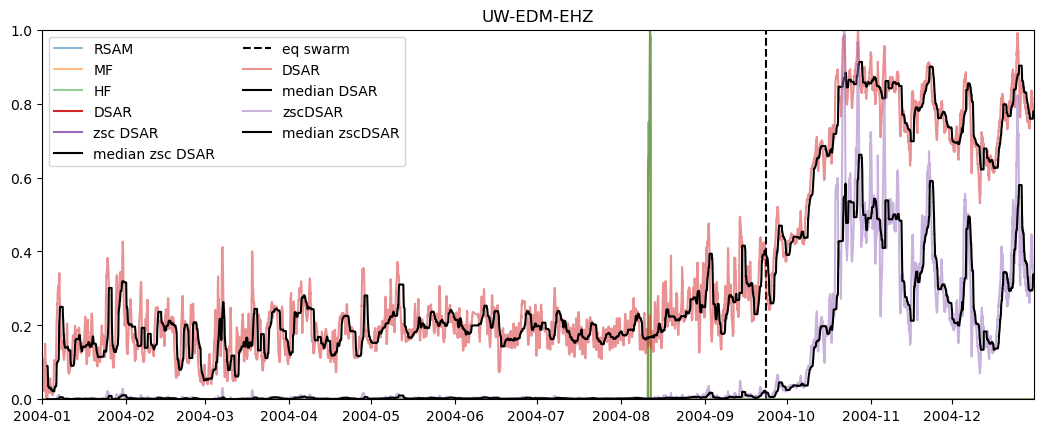

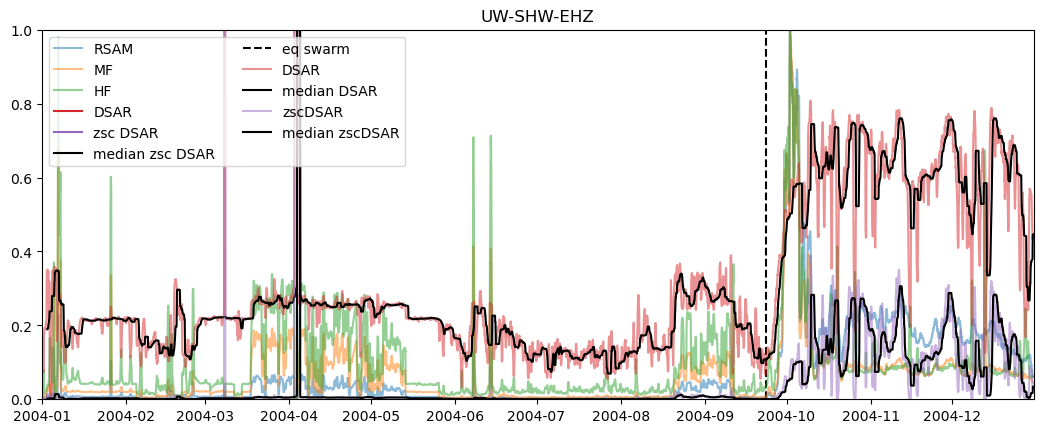

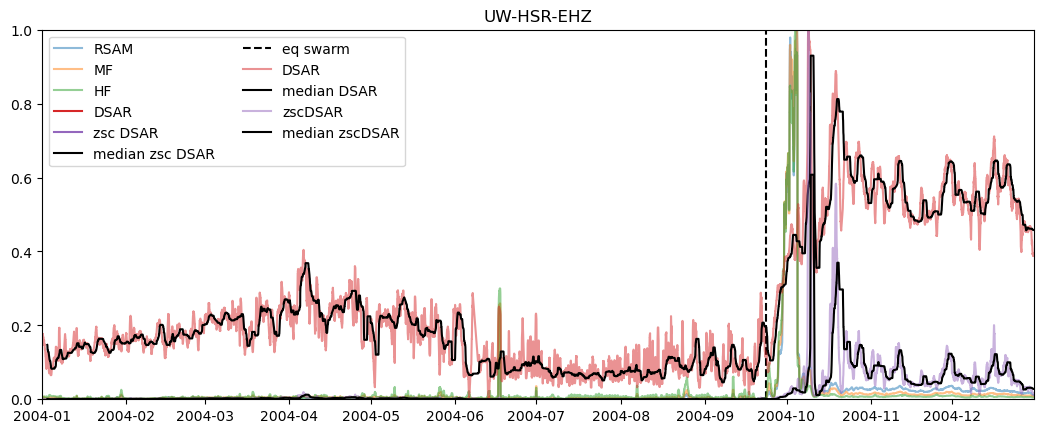

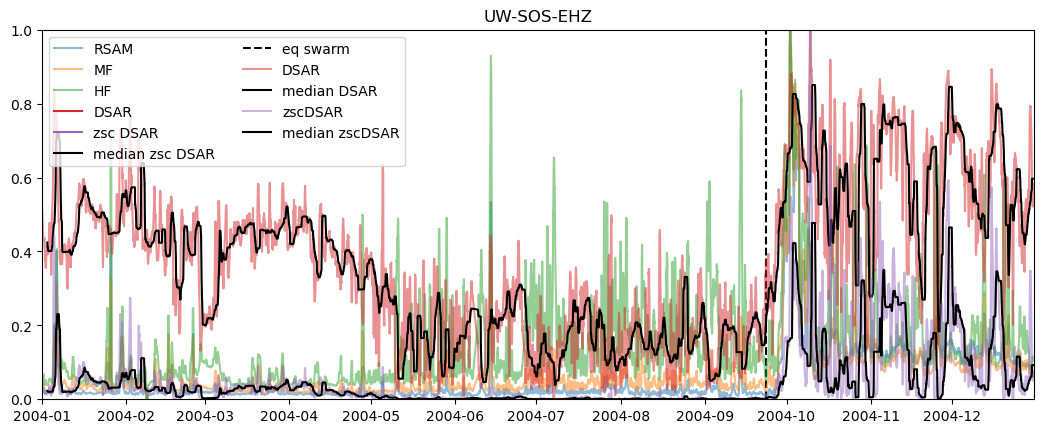

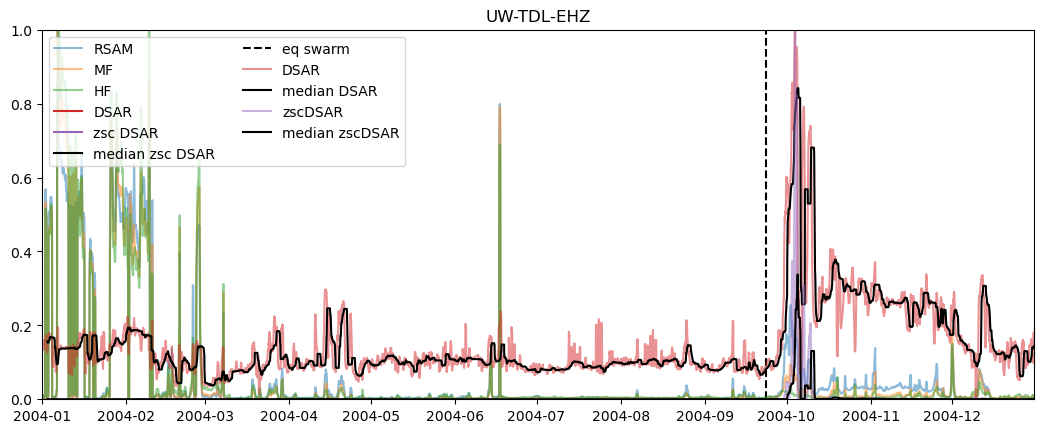

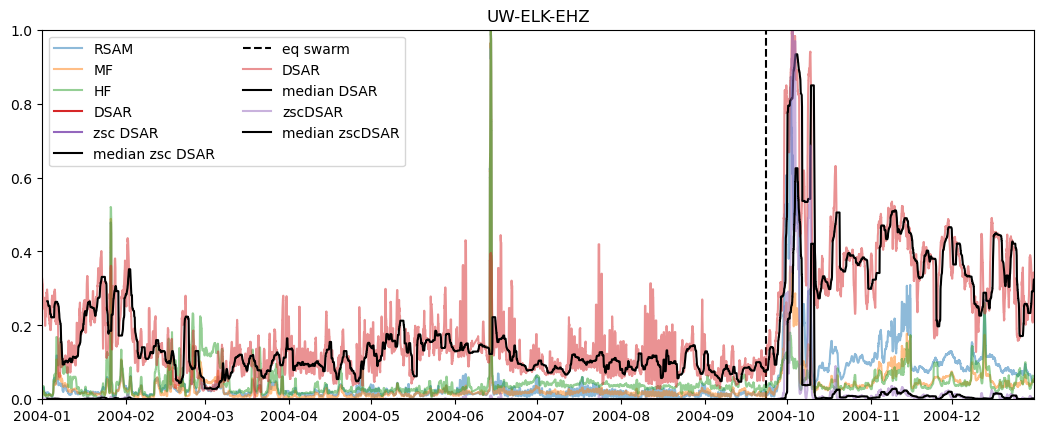

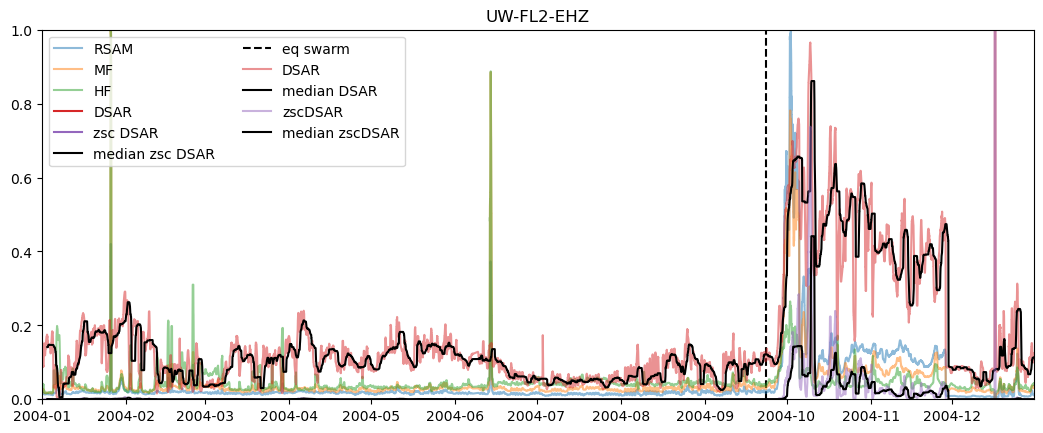

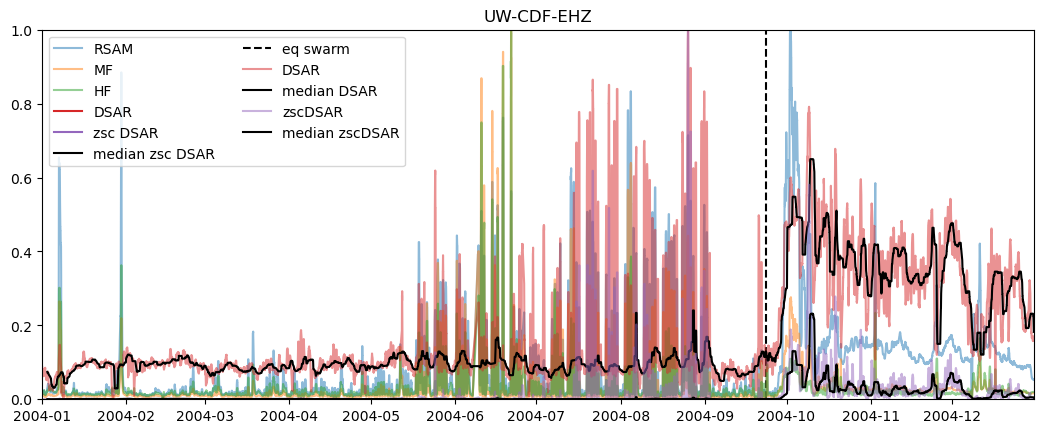

In [126]:
# NORMALIZATION
df_dsar_median = pd.DataFrame()
df_zscdsar_median = pd.DataFrame()

sta_list = ['JUN','YEL','SEP','STD','EDM','SHW','HSR','SOS','TDL','ELK','FL2','CDF']
for sta in sta_list:
#     all_files = sorted(glob.glob('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/{}/*.csv'.format(sta)))
#     li = []
#     for filename in all_files:
#         frame = pd.read_csv(filename)
#         li.append(frame)

#     df = pd.concat(li, axis=0, ignore_index=True)
#     df.set_index('time',inplace=True)
#     df.index = pd.to_datetime(df.index).tz_localize(None)
#     df.sort_index()

#     # compute transforms and save
#     df['zsc2_rsam'] = zsc2(df['rsam'])
#     df['zsc2_mf'] = zsc2(df['mf'])
#     df['zsc2_hf'] = zsc2(df['hf'])
#     df['zsc2_dsar'] = zsc2(df['dsar'])

#     df.to_csv('../{}_extended.csv'.format(sta)) #df.to_csv('.'+os.sep+'SHW_seismic_data_extended.csv')
    
    
    df = pd.read_csv('../{}_extended.csv'.format(sta))
    df.set_index('time',inplace=True)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df = df.rolling('12H', center=True).median()
    df['dsar_median'] = norm(df['dsar']).rolling(2*24*6).median()
    df['zsc2_dsar_median'] = norm(df['zsc2_dsar']).rolling(2*24*6).median()
    # df = df.resample('1H').median()
    df_dsar_median['{}'.format(sta)] = df['dsar_median']
    df_zscdsar_median['{}'.format(sta)] = df['zsc2_dsar_median']

    fig, ax = plt.subplots(1,1, sharex=True, figsize=(6.4*2, 4.8))

    ax.plot(norm(df['rsam']), label='RSAM', alpha=0.5)
    ax.plot(norm(df['mf']), label='MF', alpha=0.5)
    ax.plot(norm(df['hf']), label='HF', alpha=0.5)
    ax.plot(np.nan, label='DSAR')
    ax.plot(np.nan, label='zsc DSAR')
    ax.plot(np.nan, label='median zsc DSAR', color='k')
    ax.plot(np.nan, label='eq swarm', color='k',linestyle='--')
#     ax.set_ylim(0,5e3) # linear
    # ax.set_ylim(1e-2,1e4) # log
    # ax.set_yscale('log')

    ax.plot(norm(df['dsar']), label='DSAR', color='C3', alpha=0.5)
    ax.plot(df['dsar_median'], label='median DSAR', color='k')
#     ax2.set_ylim(0,7)

    ax.plot(norm(df['zsc2_dsar']), label='zscDSAR', color='C4', alpha=0.5)
    ax.plot(df['zsc2_dsar_median'], label='median zscDSAR', color='k')
#     ax3.set_ylim(0,120)
    ax.set_ylim(0,1)
    ax.set_xlim(df.index[0], df.index[-1])
    ax.vlines(UTCDateTime('2004-09-23T09:00:00'),ax.get_ylim()[0],ax.get_ylim()[-1], 'k','--')

    ax.set_title('UW-{}-EHZ'.format(sta))
    ax.legend(ncol=2, loc='upper left')
    fig.show()

## Multi-Station plots

In [19]:
plt.rcParams["figure.figsize"] = (6.4*2, 4.8)

In [20]:
all_files = sorted(glob.glob('../data/*_*_extended2.csv'))
sta_list = np.unique([file.split('/')[2].split('_')[1] for file in all_files])
# sta_list = sta_list[~np.isin(sta_list, ['BLIS','JRO','STD','MIDE','NED','SWFL'])]
years = range(2000,2022)

df_rsam_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
df_zscrsam_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
df_dsar_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
df_zscdsar_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))

df_rms_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
df_zscrms_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
df_pga_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
df_zscpga_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))


len_dates = len(df_rsam_median)
count = 0

for i,sta in enumerate(sta_list):
    li = []
    len_data = 0
    for year in years:
        try:
            df = pd.read_csv('../data/{}_{}_extended2.csv'.format(year,sta))
        #     df = pd.read_csv('../data/{}_extended2_long.csv'.format(sta))
            df.set_index('time',inplace=True)
            df.index = pd.to_datetime(df.index).tz_localize(None)
            df = df.resample('10min').median()
            li.append(df)
            len_data += len(df.index)
        except:
#             print(' file {}_{}_extended2.csv does not exist'.format(year,sta))
            pass
    
    if len_data > len_dates*0.25: # percent of avivable data
        df = pd.concat(li)


        df = df.apply(mask_df,axis=0) # remove outliers (the peak detection does not work well)

        df = df.rolling('6H', center=True).median()
        df['rsam_median'] = df['rsam'].rolling('2D').median()
        df['zsc2_rsam_median'] = df['zsc2_rsam'].rolling('2D').median()
        df['dsar_median'] = df['dsar'].rolling('2D').median()
        df['zsc2_dsar_median'] = df['zsc2_dsar'].rolling('2D').median()
        df['rms_median'] = df['rms'].rolling('2D').median()
        df['zsc2_rms_median'] = df['zsc2_rms'].rolling('2D').median()
        df['pga_median'] = df['pga'].rolling('2D').median()
        df['zsc2_pga_median'] = df['zsc2_pga'].rolling('2D').median()
    #     df = df.resample('1H').median()

        df = df.apply(norm,axis=0) # normalize all timesiries individual

        df += count*0.5 # to get offset

        df_rsam_median['{}'.format(sta)] = df['rsam_median']
        df_zscrsam_median['{}'.format(sta)] = df['zsc2_rsam_median']
        df_dsar_median['{}'.format(sta)] = df['dsar_median']
        df_zscdsar_median['{}'.format(sta)] = df['zsc2_dsar_median']

        df_rms_median['{}'.format(sta)] = df['rms_median']
        df_zscrms_median['{}'.format(sta)] = df['zsc2_rms_median']
        df_pga_median['{}'.format(sta)] = df['pga_median']
        df_zscpga_median['{}'.format(sta)] = df['zsc2_pga_median']
        
        count += 1
    else:
        pass
    
    sys.stdout.write('\r{} of {}'.format(i+1, len(sta_list)))
    sys.stdout.flush()

25 of 25

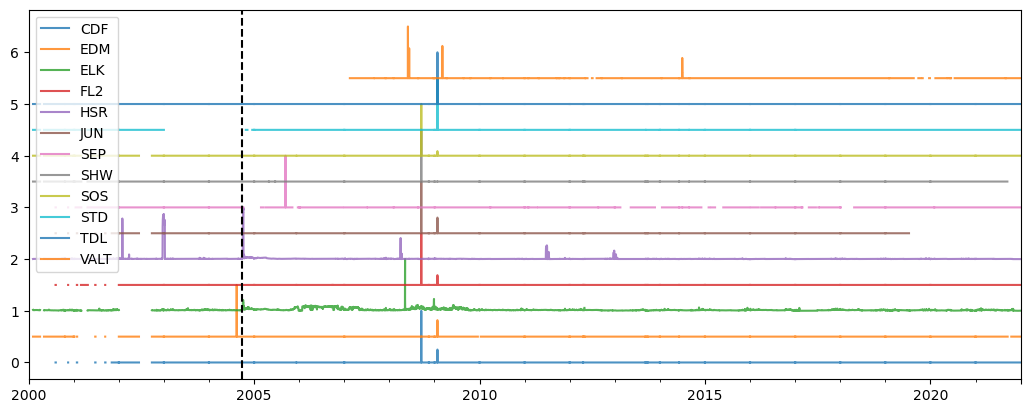

In [11]:
df_rsam_median.plot(alpha=0.8)
plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle='--')
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')
plt.legend(ncol=1, loc='upper left')

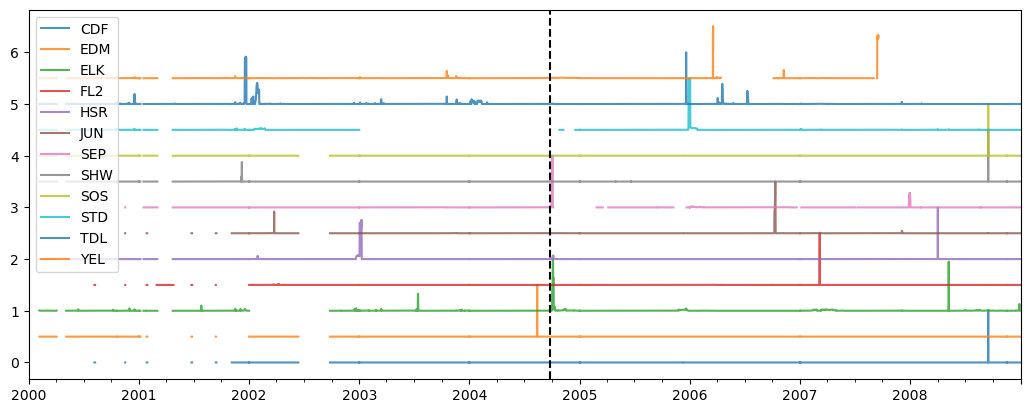

In [51]:
df_zscrsam_median.plot(alpha=0.8)
plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle='--')
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')
plt.legend(ncol=1, loc='upper left')

In [51]:
len(np.arange(0.5,(len(df_dsar_median_res.columns)+1)/2,0.5)),len(df_dsar_median.columns)

(16, 16)

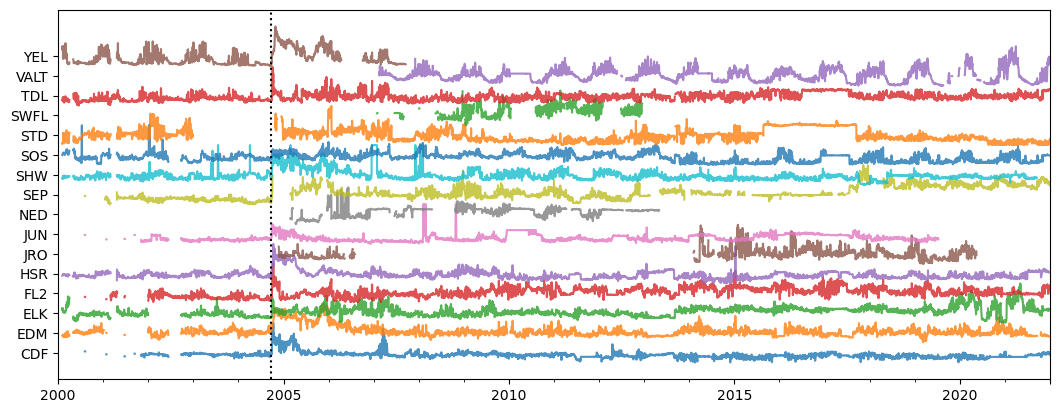

In [58]:
df_dsar_median_res = df_dsar_median.resample('1D').median()
ax = df_dsar_median_res.plot(alpha=0.8,legend=False)

ax.set_yticks(np.arange(0.25,(len(df_dsar_median_res.columns))/2,0.5))
ax.set_yticklabels(df_dsar_median.columns)

plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle=':')
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')
# plt.yticks(df_dsar_median.columns)
# plt.legend(ncol=1, loc='upper left')

In [64]:
def preprocessing(year,jday, net, sta, cha):

    try:
        # this stream will be used for RSAM and DSAR calculations
        #st = obspy.read('/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/{}/EDM.UW.2004.{}'.format(jday,jday))
        st = client.get_waveforms(network=net, station=sta, channel=cha,
                                       year='{}'.format(year), doy='{}'.format(jday))

        st.detrend('linear')
        st.taper(max_percentage=None,max_length=5, type='hann') #max_length in sec
        
        # correct insrument response
        inv = obspy.read_inventory('/auto/pnwstore1-wd11/PNWStationXML/{}/{}.{}.xml'.format(net,net,sta))
        pre_filt = [1e-3, 5e-2, 45, 50]
        water_level = 60
        
        for tr in st:
            tr.remove_response(inventory=inv, zero_mean=True,taper=True, taper_fraction=0.05,
                                      pre_filt=pre_filt, output="VEL", water_level=water_level,
                                      plot=False)

            # correct positive dip
            dip = inv.get_orientation(tr.id, datetime=tr.stats.starttime)['dip']
            if dip > 0:
                tr.data *= -1
#         st.merge(fill_value=0)
        print(':) year={}, jday={}, net={}, sta={}, cha={}'.format(year,jday, net, sta, cha))
    except:
        print('pass station {} day {}'.format(sta,jday))
    return(st)
    
def noise_analysis(data, datas, samp_rate, N, Nm):
    rms_list = []
    rmes_list = []
    pgv_list = []
    pga_list = []

    for i in np.arange(0,Nm,N): # start samples (sample, where next 10min starts)
        data_cut = data[i:i+N-1]

        rms = np.sqrt(np.mean(data_cut**2))
        rmes = np.sqrt(np.median(data_cut**2))
        pgv = max(abs(data_cut))

        data_acc = (data_cut.copy()[:-1] - data_cut.copy()[1:]) / (1/samp_rate)
        pga = max(abs(data_acc))

        rms_list.append(rms)
        rmes_list.append(rmes)
        pgv_list.append(pgv)
        pga_list.append(pga)
    datas.append(np.array(rms_list))
    datas.append(np.array(rmes_list))
    datas.append(np.array(pgv_list))
    datas.append(np.array(pga_list))
    return (datas)
    
def RSAM(data, samp_rate, datas, freq, Nm, N):
    filtered_data = obspy.signal.filter.bandpass(data, freq[0], freq[1], samp_rate)
    filtered_data = abs(filtered_data[:Nm])
    datas.append(filtered_data.reshape(-1,N).mean(axis=-1)*1.e9)
    return(datas)

def VSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N):
    # compute ratio between different velocities
    data -= np.mean(data) # detrend('mean')
    j = freqs_names.index('mf')
    mfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    mfd = abs(mfd[:Nm])
    mfd = mfd.reshape(-1,N).mean(axis=-1)
    j = freqs_names.index('hf')
    hfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    hfd = abs(hfd[:Nm])
    hfd = hfd.reshape(-1,N).mean(axis=-1)
    vsar = mfd/hfd
    datas.append(vsar)
    return(datas)

def DSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N):
    # compute dsar
    data = scipy.integrate.cumtrapz(data, dx=1./100, initial=0) # vel to disp
    data -= np.mean(data) # detrend('mean')
    j = freqs_names.index('mf')
    mfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    mfd = abs(mfd[:Nm])
    mfd = mfd.reshape(-1,N).mean(axis=-1)
    j = freqs_names.index('hf')
    hfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    hfd = abs(hfd[:Nm])
    hfd = hfd.reshape(-1,N).mean(axis=-1)
    dsar = mfd/hfd
    datas.append(dsar)
    return(datas)

def lDSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N):
    # compute dsar for low frequencies
    data = scipy.integrate.cumtrapz(data, dx=1./100, initial=0) # vel to disp
    data -= np.mean(data) # detrend('mean')
    j = freqs_names.index('rsam')
    lfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    lfd = abs(lfd[:Nm])
    lfd = lfd.reshape(-1,N).mean(axis=-1)
    j = freqs_names.index('mf')
    mfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    mfd = abs(mfd[:Nm])
    mfd = mfd.reshape(-1,N).mean(axis=-1)
    ldsar = lfd/mfd
    datas.append(ldsar)
    return(datas)

def nDSAR(datas):
    dsar = datas[3]
    ndsar = dsar/sc.stats.zscore(dsar)
    datas.append(ndsar)
    return(datas)
    
# creates a df for each trace and append this df to a daily df
# def create_df(datas, ti, freqs_names, df):
#     datas = np.array(datas)
#     time = [(ti+j*600).datetime for j in range(datas.shape[1])]
#     df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
#     df = pd.concat([df, df_tr])
#     return(df)    

def create_df(datas, ti, freqs_names, df):
    datas = np.array(datas)
    time = [(ti+j*600).datetime for j in range(datas.shape[1])]
    df_tr = pd.DataFrame(zip(*datas), columns=freqs_names+['rms','rmes','pgv','pga'], index=pd.Series(time))
    df = pd.concat([df, df_tr])
    return(df)

In [72]:
sstt = preprocessing(2000,7, 'CC', 'SWFL', '?HZ')
sstt

:) year=2000, jday=7, net=CC, sta=SWFL, cha=?HZ


0 Trace(s) in Stream:


In [73]:
len(sstt)

0

In [60]:
st = preprocessing(2020,7, 'CC', 'SEP', '?H?')
st

:) year=2020, jday=7, net=CC, sta=SEP, cha=?H?


4 Trace(s) in Stream:
CC.SEP..BHE | 2020-01-07T00:00:00.000000Z - 2020-01-07T23:59:59.980000Z | 50.0 Hz, 4320000 samples
CC.SEP..BHN | 2020-01-07T00:00:00.000000Z - 2020-01-07T23:59:59.980000Z | 50.0 Hz, 4320000 samples
CC.SEP..BHZ | 2020-01-07T00:00:00.000000Z - 2020-01-07T21:16:12.120000Z | 50.0 Hz, 3828607 samples
CC.SEP..BHZ | 2020-01-07T21:16:19.340000Z - 2020-01-07T23:59:59.980000Z | 50.0 Hz, 491033 samples

In [70]:
import time
start_time = time.time()
freqs_names = ['rsam','mf','hf','dsar','ldsar', 'vsar']
df = pd.DataFrame(columns=freqs_names)
daysec = 24*3600
freqs = [[2,5], [4.5,8], [8,16]]
        
if len(st)>0: # if stream not empty
#         st.resample(50)
    for tr in st:
        print(tr)
#         tr = st[0]
        datas = []
        data = tr.data
        samp_rate = tr.meta['sampling_rate']
        ti = tr.meta['starttime']
        # round start time to nearest 10 min increment
        tiday = obspy.UTCDateTime("{:d}-{:02d}-{:02d} 00:00:00".format(ti.year, ti.month, ti.day)) # date
        ti = tiday+int(np.round((ti-tiday)/600))*600 # nearest 10 min to starttime
        N = int(600*samp_rate)    # 10 minute windows in seconds
        Nm = int(N*np.floor(len(data)/N)) # np.floor rounds always to the smaller number
        # seconds per day (86400) * sampling rate (100) -> datapoints per day

        for freq, frequ_name in zip(freqs, freqs_names[:3]):
            datas = RSAM(data, samp_rate, datas, freq, Nm, N) # get RSAM for different frequency bands

        datas = DSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N)
        datas = lDSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N)
        datas = VSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N)
#             datas = nDSAR(datas) # --> add ndsar in freqs_names

        datas = noise_analysis(data, datas, samp_rate, N, Nm)
    
        print(datas)

        df = create_df(datas, ti, freqs_names, df)

    if not os.path.exists(file_path):
        os.makedirs(file_path)

#     df.to_csv(file_path + file_name, index=True, index_label='time')
    print(df)
    print('One day tooks {} seconds.'.format(round(time.time()-start_time),3))

CC.SEP..BHE | 2020-01-07T00:00:00.000000Z - 2020-01-07T23:59:59.980000Z | 50.0 Hz, 4320000 samples
[array([ 131.68124178,  328.55742858,  486.36274638,  503.11446108,
        583.93476298,  605.17669406,  643.54015959,  555.19393013,
        536.51650686,  525.30568029,  526.18519644,  521.05945692,
        505.3728595 ,  534.86897502,  626.35986602,  680.0700534 ,
        611.60702598,  583.28040427, 1486.02449605,  538.33110687,
        571.24657197,  997.44814515,  628.32355695,  663.92833201,
        692.76462576,  678.35258689,  601.10508061,  544.29488837,
        457.6482277 ,  532.70067819,  568.62789172,  587.96949191,
        618.65116387,  582.66229993,  657.06481449,  551.89263471,
        525.27492632,  525.1463649 ,  545.18469939,  579.59986116,
        590.21284051,  645.78201703,  648.03682127,  601.88457853,
        675.94612037,  621.43044055,  644.53252185,  702.16711027,
        779.35596776,  652.04238041,  488.40296929,  443.26087722,
        685.42287131, 1041.26

[array([ 183.68842202,  467.15813664,  682.52707374,  711.86919748,
        827.51789098,  875.96406843,  921.63318701,  796.26645094,
        755.74042671,  733.90063323,  750.26297899,  760.09223493,
        733.21519435,  764.77099299,  901.52148999,  947.67404229,
        868.7677058 ,  823.15521888, 2088.7763105 ,  772.23093596,
        815.50163882, 1391.50099817,  884.68132423,  919.26720294,
        979.96792733,  915.3793856 ,  840.38789833,  767.19197981,
        655.26216746,  748.97573264,  817.07558651,  831.93789457,
        884.64920182,  803.73167448,  919.65496449,  783.87912865,
        764.68624339,  746.07901358,  782.08366226,  826.52697696,
        826.56172863,  904.16766661,  931.754482  ,  845.98899945,
        946.06682512,  876.57028525,  892.41154442,  988.28095087,
       1057.78310705,  888.79534449,  693.17008431,  628.96999585,
        956.71689539, 1490.09393514, 1438.92212728,  994.36170853,
       1038.37049234,  973.85227379,  834.37955848,  737.5420

[array([ 46.34875929, 122.40954056, 172.48984408, 166.88172161,
       197.09210562, 201.24252063, 219.8428104 , 187.00031082,
       187.21019207, 183.03732516, 179.65213659, 174.70372868,
       176.00700749, 185.32445201, 212.3975959 , 236.03173374,
       211.98046367, 200.07803255, 413.06413833, 183.11941096,
       198.43368924, 299.00219422, 215.4395541 , 221.99300293,
       235.13564355, 223.74422523, 201.97336626, 181.84471562,
       154.610542  , 181.12429486, 196.66573287, 205.89897091,
       208.88086173, 199.46069971, 217.73344542, 192.13680777,
       179.33193497, 178.03428155, 185.27646382, 195.28720663,
       194.44264851, 207.31557147, 211.13519418, 205.383843  ,
       226.99641446, 205.53786293, 220.71266725, 236.52409966,
       269.82753842, 220.40494406, 161.28320655, 141.20815328,
       234.89226466, 372.01451813, 341.49220447, 243.52787035,
       256.49155803, 249.70451515, 214.79901736, 183.60831767,
       214.30429551, 198.51779409, 192.95098063, 204.2

In [71]:
df

rsam          mf          hf      dsar     ldsar  \
2020-01-07 00:00:00  131.681242   73.800620   48.247481  2.935328  3.649992   
2020-01-07 00:10:00  328.557429  184.222636  116.768100  2.998426  3.606257   
2020-01-07 00:20:00  486.362746  276.398211  181.540641  2.917754  3.598985   
2020-01-07 00:30:00  503.114461  278.203887  179.989231  2.992977  3.635813   
2020-01-07 00:40:00  583.934763  333.282727  215.159960  3.009033  3.521985   
...                         ...         ...         ...       ...       ...   
2020-01-07 23:10:00   34.142630   36.232949   38.476237  1.883688  1.807694   
2020-01-07 23:20:00   35.766980   39.201103   42.985392  1.820148  1.757429   
2020-01-07 23:30:00   37.557049   37.811939   37.513372  2.078534  1.882372   
2020-01-07 23:40:00   36.902357   38.972984   40.442580  1.924189  1.809534   
2020-01-07 23:50:00   41.476974   42.117602   38.927701  2.092440  1.871652   

                         vsar           rms          rmes       pgv       pga  
2020-01-07 00:00:00  1.529626  5.597355e-07  2.587474e-07  0.000003  0.000061  
2020-01-07 00:10:00  1.577679  1.333068e-06  8.357565e-07  0.000006  0.000101  
2020-01-07 00:20:00  1.522514  2.039462e-06  1.385731e-06  0.000010  0.000177  
2020-01-07 00:30:00  1.545670  2.134509e-06  1.395662e-06  0.000009  0.000134  
2020-01-07 00:40:00  1.549000  2.379282e-06  1.554089e-06  0.000012  0.000322  
...                       ...           ...           ...       ...       ...  
2020-01-07 23:10:00  0.941697  5.972686e-07  4.002604e-07  0.000002  0.000072  
2020-01-07 23:20:00  0.911963  5.662595e-07  3.813791e-07  0.000003  0.000124  
2020-01-07 23:30:00  1.007959  5.653028e-07  3.735991e-07  0.000002  0.000077  
2020-01-07 23:40:00  0.963662  6.103757e-07  4.096372e-07  0.000002  0.000145  
2020-01-07 23:50:00  1.081944  5.646138e-07  3.752411e-07  0.000003  0.000159  

[431 rows x 10 columns]

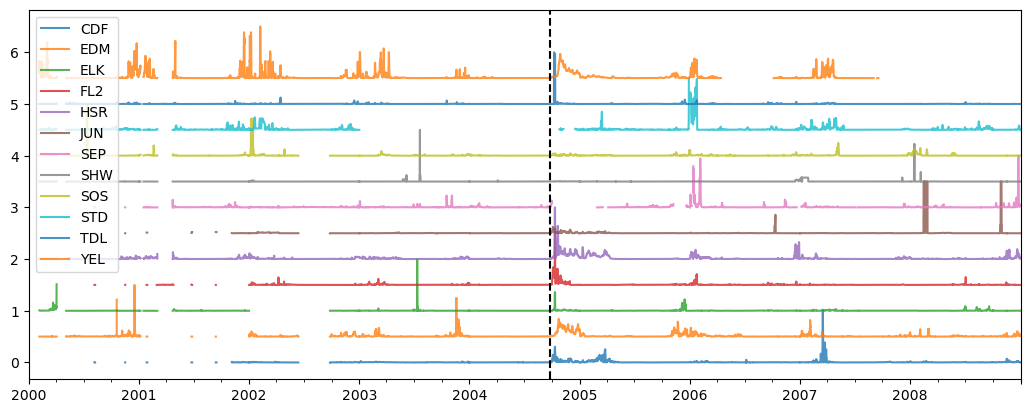

In [48]:
df_zscdsar_median.plot(alpha=0.8)
plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle='--')
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')
plt.legend(ncol=1, loc='upper left')

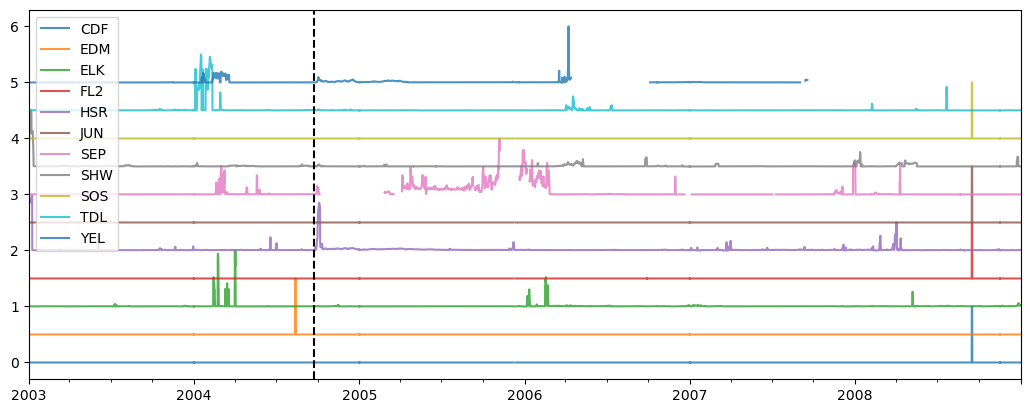

In [999]:
df_rms_median.plot(alpha=0.8)
plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle='--')
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')
plt.legend(ncol=1, loc='upper left')

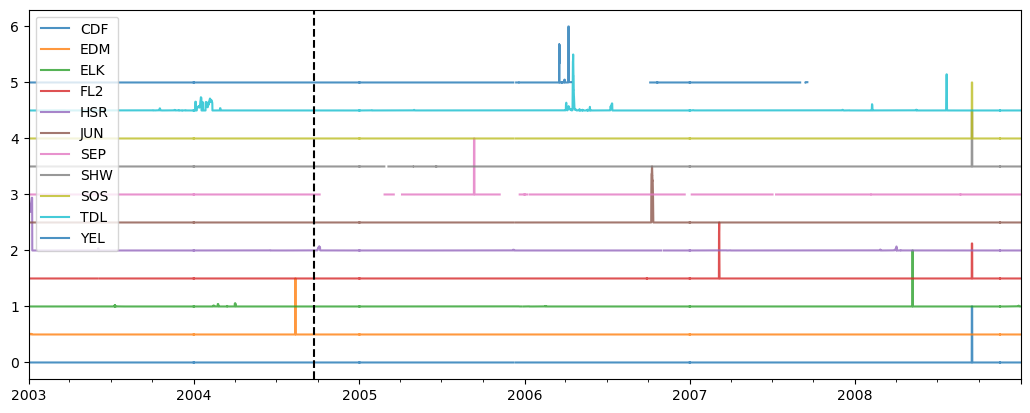

In [1000]:
df_zscrms_median.plot(alpha=0.8)
plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle='--')
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')
plt.legend(ncol=1, loc='upper left')

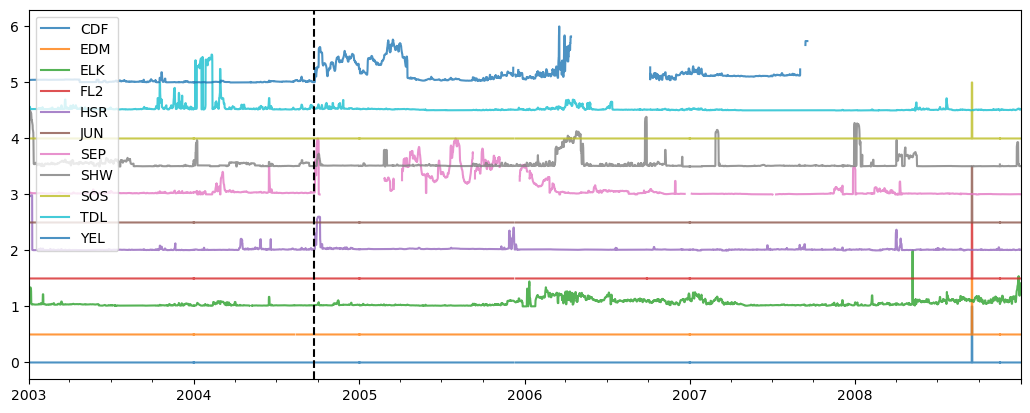

In [1001]:
df_pga_median.plot(alpha=0.8)
plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle='--')
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')
plt.legend(ncol=1, loc='upper left')

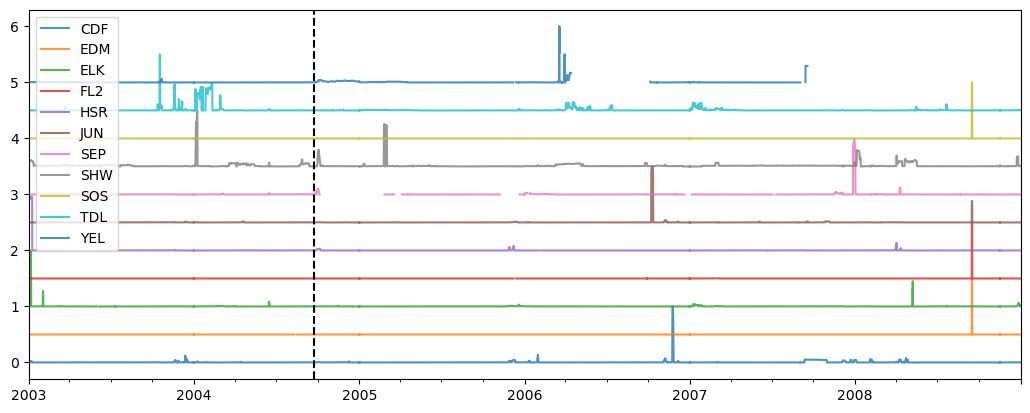

In [1002]:
df_zscpga_median.plot(alpha=0.8)
plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle='--')
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')
plt.legend(ncol=1, loc='upper left')

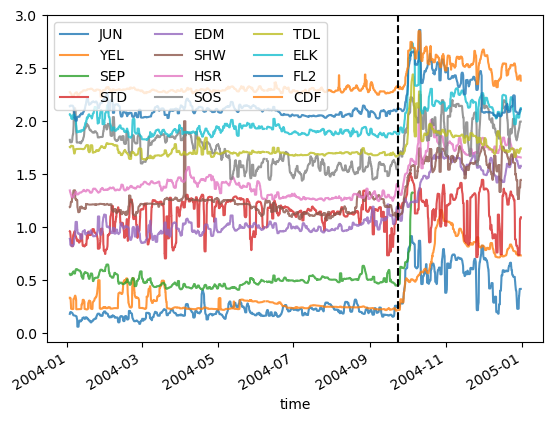

In [127]:
df_dsar_median_copy = df_dsar_median.copy()
for i in range(df_dsar_median_copy.shape[1]):
    df_dsar_median_copy.iloc[:, i] = df_dsar_median_copy.iloc[:, i]+(i*0.2)
df_dsar_median_copy.plot(alpha=0.8)
plt.axvline(UTCDateTime('2004-09-23T09:00:00'), color='k',linestyle='--')
plt.legend(ncol=3, loc='upper left')

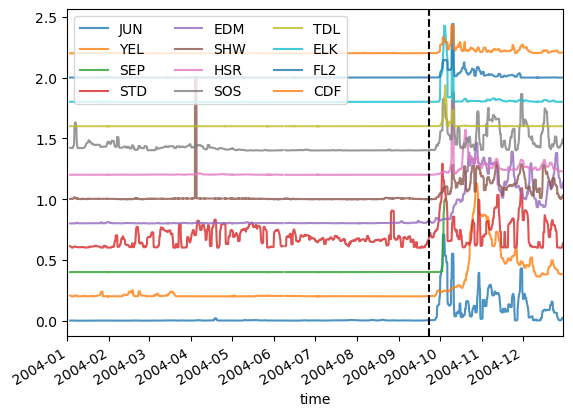

In [130]:
df_zscdsar_median_copy = df_zscdsar_median.copy()
for i in range(df_zscdsar_median_copy.shape[1]):
    df_zscdsar_median_copy.iloc[:, i] = df_zscdsar_median_copy.iloc[:, i]+(i*0.2)
df_zscdsar_median_copy.plot(alpha=0.8)
plt.xlim(df_zscdsar_median_copy.index[0],df_zscdsar_median_copy.index[-1])
plt.axvline(UTCDateTime('2004-09-23T09:00:00'), color='k',linestyle='--')
plt.legend(ncol=3, loc='upper left')

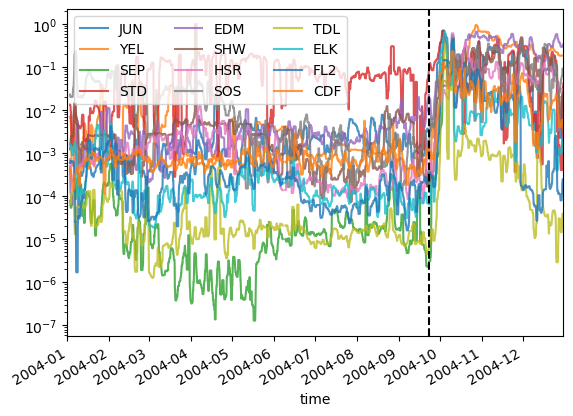

In [131]:
df_zscdsar_median_copy = df_zscdsar_median.copy()
for i in range(df_zscdsar_median_copy.shape[1]):
    df_zscdsar_median_copy.iloc[:, i] = df_zscdsar_median_copy.iloc[:, i]
df_zscdsar_median_copy.plot(alpha=0.8)
plt.xlim(df_zscdsar_median_copy.index[0],df_zscdsar_median_copy.index[-1])
plt.yscale('log')
plt.axvline(UTCDateTime('2004-09-23T09:00:00'), color='k',linestyle='--')
plt.legend(ncol=3, loc='upper left')

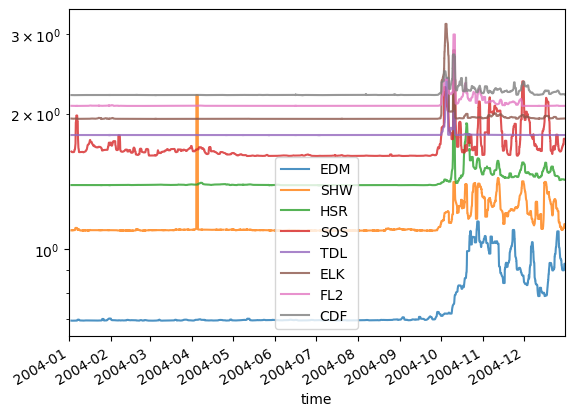

In [108]:
df_zscdsar_median_copy = df_zscdsar_median.copy()
for i in range(df_zscdsar_median_copy.shape[1]):
    df_zscdsar_median_copy.iloc[:, i] = df_zscdsar_median_copy.iloc[:, i]*np.log((i+2))+np.log((i+2))
df_zscdsar_median_copy.plot(alpha=0.8)
plt.xlim(df_zscdsar_median_copy.index[0],df_zscdsar_median_copy.index[-1])
plt.yscale('log')

<AxesSubplot:xlabel='time'>

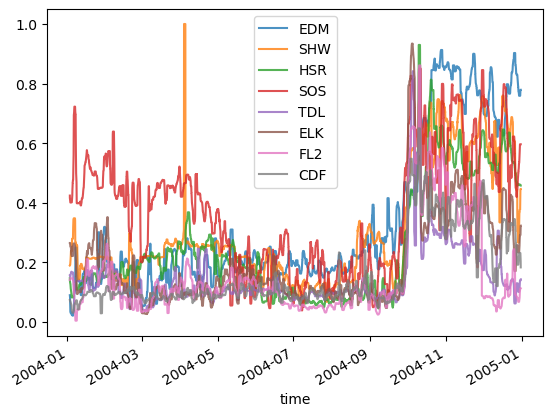

In [92]:
df_dsar_median.plot(alpha=0.8)

<AxesSubplot:xlabel='time'>

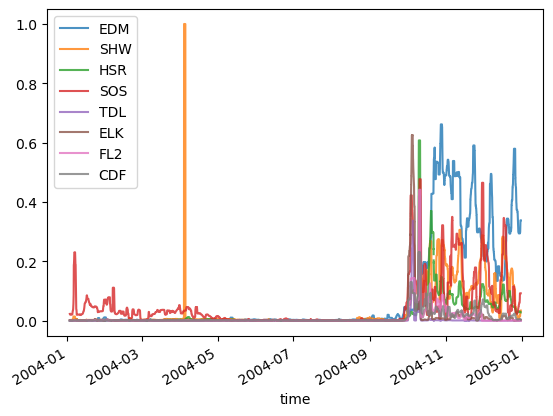

In [53]:
df_zscdsar_median.plot(alpha=0.8)